In [13]:
#initial version
#created on 25.11.2020 by kaarel
#Idea to train and predict every SOURCE_KEY separately and build window features
#Inspired by https://www.kaggle.com/furiousx7/xgboost-time-series
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold

train_data = pd.read_csv('../Data/Train_Plant1_added_features_standardized.csv')


In [14]:
def create_features(in_data):
    in_data['DATE_TIME'] = pd.to_datetime(in_data['DATE_TIME'])
    in_data["DATE"] = in_data['DATE_TIME'].dt.date
    in_data["HOUR"] = in_data['DATE_TIME'].dt.hour
    in_data["MINUTE"] = in_data['DATE_TIME'].dt.minute
    in_data["DAY_OF_YEAR"] = in_data['DATE_TIME'].dt.dayofyear
    in_data["DAY_OF_WEEK"] = in_data['DATE_TIME'].dt.dayofweek
    in_data["MONTH"] = in_data['DATE_TIME'].dt.month
    in_data["DAY_OF_MONTH"] = in_data['DATE_TIME'].dt.day


train_columns = [
       'HOUR',
       'MINUTE',
       'DAY_OF_YEAR',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2',
       'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3',
       'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']


In [15]:
#
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()


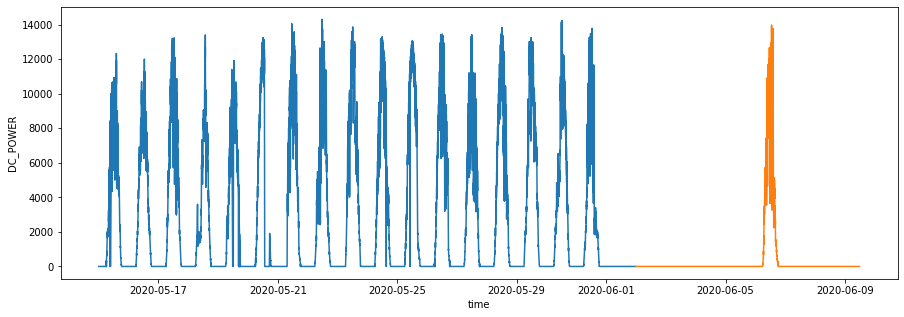

In [16]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(pred_train["DATE_TIME"],pred_train.DC_POWER)
plt.plot(pred_test["DATE_TIME"],pred_test.DC_POWER)
plt.show()

In [17]:
import numpy as np
predict_column = 'DC_POWER'
prediction_models = []
reg = xgb.XGBRegressor(n_estimators=10000)
reg.fit(pred_train[train_columns], pred_train[predict_column],
        eval_set=[(pred_train[train_columns], pred_train[predict_column]), (pred_test[train_columns], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)
prediction_models.append(reg)

[0]	validation_0-rmse:3607.21582	validation_1-rmse:1684.14404
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2677.44995	validation_1-rmse:1683.02454
[2]	validation_0-rmse:2059.13110	validation_1-rmse:1694.30322
[3]	validation_0-rmse:1631.55542	validation_1-rmse:1710.87036
[4]	validation_0-rmse:1344.28906	validation_1-rmse:1724.27966
[5]	validation_0-rmse:1135.08984	validation_1-rmse:1723.48486
[6]	validation_0-rmse:1026.06628	validation_1-rmse:1723.87830
[7]	validation_0-rmse:959.37335	validation_1-rmse:1732.44287
[8]	validation_0-rmse:887.91638	validation_1-rmse:1749.06165
[9]	validation_0-rmse:839.38245	validation_1-rmse:1753.08398
[10]	validation_0-rmse:786.52997	validation_1-rmse:1759.30579
[11]	validation_0-rmse:740.83380	validation_1-rmse:1758.88318
[12]	validation_0-rmse:703.46332	validation_1-rmse:1761.05066
[13]	validation_0-rmse:681.03076	valid

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

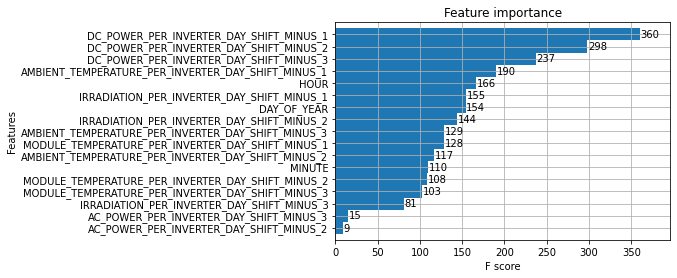

In [18]:
xgb.plot_importance(reg, height=1)

In [19]:
val_predictions = reg.predict(pred_test[train_columns])


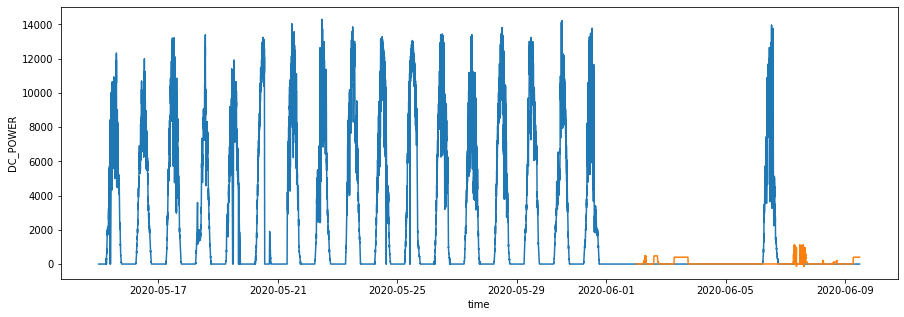

In [20]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data["DATE_TIME"],train_data.DC_POWER)
plt.plot(pred_test["DATE_TIME"],val_predictions)
plt.show()

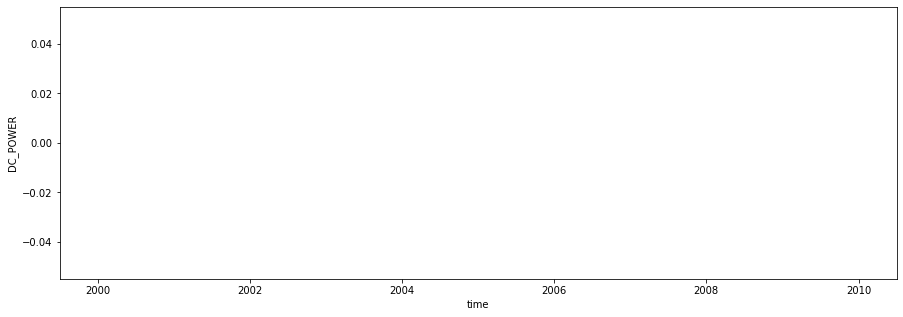

In [21]:
#SINGLE INVERTER

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('DC_POWER')
plt.plot(train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],train_data[train_data.SOURCE_KEY == '4UPUqMRk7TRMgml']["DC_POWER"])
plt.plot(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml']["DATE_TIME"],reg.predict(pred_test[pred_test.SOURCE_KEY == '4UPUqMRk7TRMgml'][train_columns]))
plt.show()

In [22]:
#Features selection try all combinations in a set and choose best set
from itertools import combinations
def get_feature_set_rmse(train_columns):
    k = len(train_columns)-1
    print(k)
    new_train_columns = list(combinations(train_columns,k))
    prediction_models = []
    for t in new_train_columns:
        reg = xgb.XGBRegressor(n_estimators=10000)
        reg.fit(pred_train[np.asarray(t)], pred_train[predict_column],
            eval_set=[(pred_train[np.asarray(t)], pred_train[predict_column]), (pred_test[np.asarray(t)], pred_test[predict_column])],
            early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
            verbose=False)
        test_predictions = reg.predict(pred_test[np.asarray(t)])
        RMSE = mean_squared_error(pred_test[predict_column], test_predictions)
        prediction_models.append(RMSE)
        print(RMSE, t)
    return (prediction_models, new_train_columns)


In [23]:
#(models_performance, testes_features) = get_feature_set_rmse(train_columns)

In [24]:
best_models = []
initial_columns = train_columns.copy()
for k in np.arange(len(initial_columns),1,-1):
    (prediction_models, new_train_columns) = get_feature_set_rmse(initial_columns)
    current_loop_best = np.argmin(prediction_models)
    best_models.append((prediction_models[current_loop_best], new_train_columns[current_loop_best]))
    initial_columns = new_train_columns[current_loop_best]
    print('BEST:',prediction_models[current_loop_best],new_train_columns[current_loop_best])

16
2832862.4563869373 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3')
2832575.7356719077 ('HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_D

In [31]:
#https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


In [34]:
from sklearn.metrics import accuracy_score
train_columns = ['HOUR', 'MINUTE', 'DAY_OF_YEAR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_3', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [(pred_train[train_columns], pred_train[predict_column]), (pred_test[train_columns], pred_test[predict_column])]
    clf.fit(pred_train[train_columns], pred_train[predict_column],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(pred_test[train_columns])
    accuracy = accuracy_score(pred_test[predict_column], pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [35]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


job exception: y contains previously unseen labels: [0.2857142857142857, 0.4666666666666668, 0.4933333333333334, 0.4933333333333335, 0.5, 0.5066666666666666, 0.5466666666666666, 0.5866666666666666, 0.6133333333333333, 0.6214285714285713, 0.6266666666666666, 0.6571428571428571, 0.6714285714285714, 0.7600000000000002, 1.1466666666666665, 1.1666666666666663, 1.1785714285714286, 1.22, 1.2214285714285715, 1.2399999999999998, 1.2500000000000002, 1.26, 1.2642857142857142, 1.2666666666666668, 1.3200000000000005, 1.3357142857142854, 1.3428571428571427, 1.5800000000000003, 1.7599999999999996, 1.7666666666666666, 1.8, 1.8266666666666669, 2.006666666666667, 2.06, 2.14, 2.142857142857143, 2.2, 2.2642857142857142, 2.271428571428572, 2.293333333333333, 2.333333333333333, 2.5066666666666664, 2.5600000000000005, 2.5933333333333333, 2.6, 2.7, 2.707142857142857, 2.7533333333333325, 2.7533333333333334, 2.7571428571428567, 2.821428571428571, 2.85, 3.026666666666668, 3.140000000000001, 3.171428571428572, 3.

ValueError: y contains previously unseen labels: [0.2857142857142857, 0.4666666666666668, 0.4933333333333334, 0.4933333333333335, 0.5, 0.5066666666666666, 0.5466666666666666, 0.5866666666666666, 0.6133333333333333, 0.6214285714285713, 0.6266666666666666, 0.6571428571428571, 0.6714285714285714, 0.7600000000000002, 1.1466666666666665, 1.1666666666666663, 1.1785714285714286, 1.22, 1.2214285714285715, 1.2399999999999998, 1.2500000000000002, 1.26, 1.2642857142857142, 1.2666666666666668, 1.3200000000000005, 1.3357142857142854, 1.3428571428571427, 1.5800000000000003, 1.7599999999999996, 1.7666666666666666, 1.8, 1.8266666666666669, 2.006666666666667, 2.06, 2.14, 2.142857142857143, 2.2, 2.2642857142857142, 2.271428571428572, 2.293333333333333, 2.333333333333333, 2.5066666666666664, 2.5600000000000005, 2.5933333333333333, 2.6, 2.7, 2.707142857142857, 2.7533333333333325, 2.7533333333333334, 2.7571428571428567, 2.821428571428571, 2.85, 3.026666666666668, 3.140000000000001, 3.171428571428572, 3.2333333333333334, 3.26, 3.36, 3.3866666666666667, 3.4333333333333327, 3.435714285714285, 3.4714285714285715, 3.506666666666667, 3.5071428571428567, 3.5133333333333336, 3.5333333333333328, 3.6000000000000005, 3.6066666666666665, 3.706666666666667, 3.746666666666668, 3.792857142857143, 3.9333333333333336, 4.006666666666667, 4.033333333333334, 4.06, 4.086666666666668, 4.1066666666666665, 4.173333333333333, 4.307142857142857, 4.34, 4.386666666666667, 4.450000000000001, 4.471428571428572, 4.586666666666666, 4.621428571428573, 4.635714285714286, 4.6466666666666665, 4.666666666666667, 4.68, 4.6933333333333325, 4.7, 4.721428571428572, 4.726666666666667, 4.7285714285714295, 4.7333333333333325, 4.806666666666667, 4.828571428571427, 4.846666666666667, 4.866666666666667, 4.885714285714286, 4.8928571428571415, 4.942857142857143, 5.0666666666666655, 5.164285714285714, 5.233333333333333, 5.3, 5.333333333333333, 5.386666666666668, 5.4785714285714295, 5.493333333333334, 5.6800000000000015, 5.753333333333333, 5.7714285714285705, 5.813333333333333, 5.814285714285713, 5.846666666666668, 5.8533333333333335, 5.886666666666668, 5.913333333333334, 5.953333333333334, 5.96, 5.993333333333334, 6.071428571428571, 6.207142857142856, 6.466666666666666, 6.726666666666668, 6.753333333333333, 6.780000000000002, 6.833333333333332, 6.993333333333331, 9.206666666666667, 10.486666666666666, 11.58, 11.646666666666668, 11.72, 11.953333333333333, 11.959999999999996, 11.96, 12.128571428571426, 12.157142857142858, 12.193333333333333, 12.253333333333336, 12.273333333333332, 12.353333333333332, 12.36, 12.453333333333333, 12.464285714285715, 12.566666666666665, 12.573333333333332, 12.613333333333333, 12.64, 12.692857142857143, 12.72, 12.733333333333333, 12.733333333333334, 12.760000000000002, 12.766666666666667, 12.773333333333335, 12.78, 12.814285714285715, 12.821428571428573, 12.864285714285714, 12.964285714285715, 12.966666666666665, 13.046666666666665, 13.053333333333333, 13.064285714285711, 13.085714285714287, 13.086666666666664, 13.093333333333335, 13.126666666666665, 13.24, 13.240000000000002, 13.293333333333333, 13.3, 13.326666666666664, 13.340000000000002, 13.357142857142856, 13.4, 13.406666666666668, 13.52, 13.693333333333333, 13.773333333333332, 13.826666666666664, 13.913333333333332, 13.92, 13.949999999999998, 13.966666666666665, 14.006666666666666, 14.006666666666668, 14.053333333333335, 14.073333333333332, 14.107142857142858, 14.173333333333328, 14.266666666666666, 14.346666666666666, 14.535714285714285, 14.553333333333335, 14.600000000000005, 14.606666666666666, 14.646666666666668, 14.726666666666665, 14.753333333333336, 14.806666666666667, 14.892857142857142, 14.919999999999998, 15.053333333333333, 15.106666666666667, 15.2, 15.34, 16.7, 17.021428571428572, 17.21333333333333, 17.393333333333334, 17.46, 17.614285714285714, 17.84285714285714, 18.053333333333327, 18.24, 18.34, 18.364285714285714, 18.473333333333336, 18.633333333333336, 18.653333333333336, 18.866666666666667, 18.973333333333333, 19.1, 19.126666666666672, 19.22, 19.406666666666666, 19.5, 19.54, 19.546666666666667, 19.613333333333333, 19.8, 19.806666666666672, 19.926666666666666, 19.966666666666665, 20.01333333333333, 20.02, 20.053333333333327, 20.073333333333334, 20.146666666666672, 20.273333333333326, 20.306666666666665, 20.446666666666676, 20.553333333333327, 20.593333333333334, 20.707142857142856, 21.042857142857144, 21.28, 21.74, 21.86666666666667, 21.98, 21.99285714285714, 22.085714285714282, 22.15, 22.278571428571425, 22.30666666666667, 22.4, 22.42, 22.69333333333333, 22.73333333333333, 22.807142857142853, 22.81333333333333, 22.84666666666667, 23.04, 23.18, 23.38666666666667, 23.44, 23.68, 23.68666666666667, 23.76, 23.93333333333333, 24.07857142857143, 24.186666666666664, 24.34666666666667, 24.47333333333334, 24.520000000000003, 24.66, 24.76, 24.77333333333333, 24.78, 24.82142857142857, 24.857142857142854, 24.906666666666666, 24.98666666666666, 25.35333333333333, 25.43333333333333, 25.55333333333333, 25.56, 25.62666666666667, 25.653333333333336, 25.65333333333334, 25.69333333333333, 25.79333333333333, 25.85333333333333, 25.94, 25.94666666666667, 25.96666666666667, 25.993333333333336, 26.06, 26.17333333333333, 26.23333333333333, 26.33333333333333, 26.34, 26.366666666666664, 26.414285714285718, 26.43333333333333, 26.49333333333333, 26.5, 26.606666666666666, 26.61333333333333, 26.673333333333336, 26.67857142857143, 26.68666666666667, 26.70666666666667, 26.72666666666667, 26.76, 26.842857142857145, 26.906666666666666, 26.99333333333333, 27.099999999999994, 27.14, 27.14666666666667, 27.23333333333333, 27.29285714285714, 27.29333333333333, 27.366666666666664, 27.36666666666667, 27.478571428571428, 27.54666666666667, 27.6, 27.60666666666667, 27.61333333333333, 27.66666666666667, 27.72666666666667, 27.80666666666667, 27.820000000000004, 27.82666666666667, 27.846666666666664, 27.92, 27.926666666666666, 27.94, 28.0, 28.186666666666664, 28.26666666666667, 28.29333333333334, 28.30666666666667, 28.333333333333336, 28.340000000000003, 28.38666666666667, 28.4, 28.47333333333333, 28.52666666666667, 28.564285714285717, 28.6, 28.619999999999994, 28.626666666666665, 28.680000000000003, 28.706666666666663, 28.74666666666667, 28.75333333333333, 28.81333333333333, 28.86666666666667, 28.87333333333333, 28.91333333333333, 28.97333333333333, 29.021428571428572, 29.12, 29.133333333333336, 29.21333333333333, 29.24666666666667, 29.29333333333333, 29.30666666666667, 29.57333333333333, 29.58, 29.61333333333333, 29.63076923076923, 29.81333333333333, 29.866666666666664, 30.013333333333332, 30.02, 30.06666666666667, 30.14666666666667, 30.17333333333333, 30.246666666666666, 30.49333333333333, 30.61333333333333, 30.7, 30.71428571428571, 30.73333333333333, 30.739999999999995, 30.96, 31.02000000000001, 31.07857142857143, 31.08666666666667, 31.16, 31.21333333333333, 31.23333333333333, 31.414285714285718, 31.642857142857146, 32.2, 32.37333333333333, 32.446666666666665, 32.46666666666666, 32.606666666666676, 33.36000000000001, 33.49999999999999, 33.66428571428571, 33.91333333333333, 34.06666666666667, 34.36, 34.42666666666668, 34.74666666666667, 35.09333333333334, 35.32857142857142, 35.61999999999999, 35.62666666666667, 35.69333333333333, 35.72857142857143, 35.80666666666667, 35.88, 35.946666666666665, 36.15714285714285, 36.52142857142857, 36.586666666666666, 36.63333333333335, 36.64, 36.64285714285713, 36.72142857142856, 36.74285714285714, 36.75714285714286, 37.02000000000001, 37.04666666666667, 37.06428571428571, 37.092857142857135, 37.09333333333335, 37.30714285714287, 37.32666666666667, 37.457142857142856, 37.50666666666668, 37.67142857142857, 37.73571428571429, 37.81333333333333, 37.88666666666667, 38.15999999999999, 38.16, 38.17333333333333, 38.2, 38.426666666666655, 38.46, 38.48, 38.89333333333333, 39.286666666666655, 39.4, 39.43999999999999, 39.48571428571429, 39.486666666666665, 39.566666666666656, 39.64666666666667, 39.66, 39.86666666666667, 39.926666666666655, 39.966666666666654, 40.092857142857135, 40.157142857142865, 40.36, 40.41333333333334, 40.54285714285713, 40.71333333333333, 40.878571428571426, 40.89333333333335, 40.906666666666666, 40.91428571428571, 40.921428571428564, 40.99333333333333, 41.1142857142857, 41.18, 41.193333333333335, 41.22666666666667, 41.373333333333335, 41.56, 41.67333333333333, 41.68000000000001, 42.09333333333333, 42.12666666666667, 42.2, 42.34666666666666, 42.373333333333335, 42.433333333333344, 42.44285714285713, 42.446666666666665, 42.78, 42.806666666666665, 43.05999999999999, 43.10666666666666, 43.16, 43.18571428571429, 43.39285714285713, 43.46666666666666, 43.48, 43.54666666666666, 43.55333333333334, 43.62000000000001, 43.63333333333333, 43.66, 43.67333333333334, 43.72, 43.73571428571428, 43.82, 44.07333333333334, 44.164285714285704, 44.17857142857143, 44.67999999999999, 44.72666666666666, 44.79285714285713, 45.214285714285715, 45.26000000000001, 45.31428571428572, 45.94000000000001, 46.59333333333333, 47.09285714285714, 47.10666666666666, 47.43999999999999, 47.44666666666667, 47.57857142857142, 47.62666666666667, 47.714285714285715, 47.92, 48.00666666666666, 48.25333333333334, 48.38666666666666, 48.61428571428571, 48.62000000000001, 48.62142857142857, 48.71333333333333, 48.90714285714286, 48.94666666666666, 49.35, 49.72666666666667, 49.85, 50.30000000000001, 50.7, 50.90000000000001, 52.08666666666667, 52.61333333333334, 52.69333333333334, 52.78666666666666, 52.98666666666666, 53.13333333333333, 53.35333333333334, 53.40666666666666, 53.84285714285714, 53.86000000000001, 53.86666666666667, 54.08666666666666, 54.2, 54.44, 54.55333333333334, 54.72000000000001, 54.77333333333334, 54.92666666666666, 54.94666666666667, 54.98, 55.05333333333334, 55.24, 55.29333333333333, 55.31333333333333, 55.33571428571428, 55.34285714285714, 55.38571428571429, 55.44, 55.47333333333333, 55.514285714285705, 55.735714285714295, 55.75999999999999, 55.92000000000001, 55.94285714285715, 55.973333333333336, 55.99333333333334, 56.08, 56.12666666666667, 56.15714285714286, 56.16666666666666, 56.3, 56.34666666666667, 56.35333333333334, 56.68666666666666, 56.71333333333333, 56.75999999999999, 56.78571428571429, 56.85999999999999, 56.871428571428574, 56.91333333333333, 56.98666666666666, 57.01333333333334, 57.08000000000001, 57.16, 57.16666666666667, 57.21333333333334, 57.28666666666666, 57.61333333333334, 57.74666666666666, 57.75333333333333, 57.786666666666676, 57.86, 57.90666666666667, 58.06666666666667, 58.3, 58.46, 58.526666666666664, 58.52666666666667, 58.55333333333334, 58.67333333333333, 58.85333333333334, 58.87333333333334, 59.17333333333334, 59.24666666666666, 59.31333333333333, 59.32, 59.36666666666667, 59.44, 59.60714285714286, 59.63333333333334, 59.66, 59.66666666666666, 59.72000000000001, 59.76666666666666, 59.79333333333334, 59.92, 59.92666666666666, 60.03333333333333, 60.41333333333333, 60.72000000000001, 60.78666666666666, 60.84666666666666, 60.88666666666666, 60.9, 60.92, 60.93333333333333, 60.957142857142856, 60.98666666666667, 61.01333333333333, 61.21333333333335, 61.37333333333333, 61.42, 61.44666666666666, 61.45333333333334, 61.48, 61.61333333333334, 61.71333333333333, 61.75333333333334, 61.77333333333334, 61.82666666666666, 61.91333333333333, 61.95333333333333, 62.11333333333333, 62.11333333333334, 62.20000000000002, 62.214285714285715, 62.45333333333333, 62.521428571428565, 62.74666666666666, 62.78666666666666, 62.96428571428571, 63.06428571428572, 63.08666666666666, 63.14666666666666, 63.171428571428564, 63.19333333333334, 63.22, 63.35333333333333, 63.38000000000002, 63.48666666666666, 63.7, 63.72, 64.12666666666667, 64.56428571428572, 64.58, 64.67857142857143, 64.77857142857144, 64.82, 64.84666666666666, 65.01333333333334, 65.06, 65.1857142857143, 65.31333333333333, 65.36666666666666, 65.55333333333333, 65.71428571428571, 65.94285714285715, 66.09333333333333, 66.16000000000001, 66.17999999999999, 66.18571428571425, 66.19333333333333, 66.21333333333332, 66.52666666666666, 66.55, 66.55000000000001, 66.61999999999998, 66.65333333333332, 66.74666666666666, 66.92666666666668, 67.28000000000002, 67.37999999999998, 67.78666666666666, 67.80666666666666, 67.81333333333333, 67.85, 68.0, 68.04285714285714, 68.07333333333334, 68.29333333333332, 68.34666666666666, 68.38666666666667, 68.57857142857142, 68.58571428571429, 68.66666666666669, 68.94000000000001, 68.96666666666665, 68.97333333333336, 69.10666666666665, 69.11333333333333, 69.14666666666666, 69.17999999999999, 69.19333333333333, 69.23333333333333, 69.44, 69.51333333333332, 69.53999999999998, 69.55333333333333, 69.59333333333335, 69.75333333333333, 69.96666666666665, 70.06, 70.15999999999998, 70.27999999999999, 70.31333333333332, 70.66666666666667, 70.77333333333334, 71.24000000000002, 71.39333333333333, 71.39333333333335, 71.87333333333333, 72.59333333333333, 73.04285714285714, 73.06666666666666, 73.11333333333334, 73.16666666666666, 73.38666666666666, 73.42142857142856, 73.47142857142858, 73.49999999999999, 73.57333333333334, 73.58666666666667, 73.71333333333334, 73.75333333333333, 73.84, 73.92666666666669, 74.22666666666667, 74.24, 74.5, 74.50000000000001, 74.72857142857143, 74.74, 74.99999999999999, 75.0466666666667, 75.29333333333334, 75.42857142857143, 75.47999999999998, 75.82666666666665, 76.06666666666666, 76.13999999999999, 76.15, 76.22000000000001, 76.37333333333333, 76.51428571428573, 76.66000000000003, 76.66666666666664, 76.76666666666667, 76.95333333333333, 77.14000000000001, 77.14285714285717, 77.19285714285714, 77.37142857142858, 77.47333333333333, 77.53333333333335, 77.61999999999998, 77.81333333333335, 77.88666666666667, 77.93571428571427, 77.97333333333333, 78.0933333333333, 78.16666666666666, 78.19333333333334, 78.2, 78.24000000000002, 78.27142857142857, 78.32666666666665, 78.36428571428571, 78.42, 78.55333333333334, 78.72666666666667, 78.74285714285716, 78.74666666666667, 78.75999999999998, 78.8142857142857, 78.86666666666667, 78.94666666666667, 78.95333333333333, 78.97999999999998, 79.04000000000002, 79.24, 79.32, 79.34666666666666, 79.45333333333333, 79.47999999999998, 79.6, 79.60666666666667, 79.69333333333331, 79.92666666666666, 79.94000000000003, 80.00666666666666, 80.16666666666666, 80.2285714285714, 80.25714285714284, 80.27333333333331, 80.31333333333333, 80.43333333333334, 80.5933333333333, 80.79999999999998, 80.82, 80.85333333333331, 80.92, 80.92666666666669, 81.01333333333334, 81.10666666666665, 81.28, 81.3, 81.30000000000003, 81.44666666666667, 81.61333333333334, 81.8, 81.82, 81.95999999999998, 82.06, 82.13999999999999, 82.28000000000002, 82.34, 82.41333333333334, 82.44000000000003, 82.47999999999998, 82.78000000000002, 82.79333333333334, 82.88000000000002, 82.92, 82.93333333333334, 83.0, 83.10000000000002, 83.20666666666666, 83.21999999999998, 83.27333333333331, 83.45333333333333, 83.59333333333333, 83.75333333333332, 83.99333333333334, 84.01333333333334, 84.03333333333335, 84.18, 84.25333333333333, 84.2666666666667, 84.49999999999999, 84.54666666666662, 84.58, 84.74, 84.78, 84.84666666666666, 84.89999999999998, 84.9866666666667, 85.32, 85.35333333333334, 85.6, 85.64666666666669, 85.7, 85.94000000000004, 86.0, 86.00666666666667, 86.01333333333334, 86.26, 86.30666666666664, 86.43333333333332, 86.46, 86.46666666666668, 86.74666666666668, 87.04666666666668, 87.13333333333333, 87.18666666666665, 87.46428571428574, 88.51333333333332, 89.06, 90.00666666666667, 90.19285714285715, 90.24, 90.5, 90.75, 91.21333333333332, 91.23571428571432, 91.90666666666668, 91.92, 92.16666666666669, 92.18666666666664, 92.52666666666669, 92.63333333333333, 92.83333333333331, 92.87333333333336, 93.12142857142857, 93.43571428571428, 93.51999999999998, 93.58, 93.87333333333332, 93.99285714285715, 94.60666666666668, 94.62, 94.79333333333336, 94.82857142857141, 94.89333333333332, 94.92666666666668, 94.92857142857143, 94.99333333333333, 95.00666666666666, 95.51333333333332, 95.90666666666668, 95.98571428571428, 96.12, 96.18, 96.37333333333332, 96.43333333333332, 96.44666666666667, 96.48, 96.53333333333332, 96.58666666666666, 96.71333333333332, 96.83333333333334, 97.00714285714285, 97.03333333333332, 97.05333333333334, 97.06, 97.08666666666667, 97.09333333333332, 97.14, 97.22, 97.26666666666668, 97.44, 97.47333333333334, 97.62, 97.67333333333332, 97.71999999999998, 97.74, 97.75, 98.66000000000004, 98.72857142857141, 98.81333333333336, 99.03333333333332, 99.16666666666669, 99.21333333333332, 99.26000000000002, 99.32142857142858, 99.48666666666666, 99.64, 99.68571428571428, 99.80714285714286, 99.92666666666666, 100.08, 100.15714285714287, 100.55333333333336, 100.75333333333332, 100.84666666666666, 100.91428571428571, 100.92, 100.96, 101.12142857142858, 101.23333333333336, 101.27142857142857, 101.4, 101.6, 101.72857142857141, 101.82666666666668, 102.02142857142857, 102.06428571428572, 102.21999999999998, 102.26666666666668, 102.30666666666669, 102.57142857142857, 102.61333333333332, 102.83333333333331, 103.2, 103.36666666666667, 103.51333333333334, 103.54666666666664, 103.59333333333336, 103.71428571428572, 103.82666666666668, 103.97333333333334, 104.01428571428572, 104.05333333333333, 104.21428571428572, 104.37333333333336, 104.54285714285713, 104.56666666666666, 104.57142857142857, 104.58571428571429, 104.70666666666666, 104.80666666666666, 104.98666666666664, 105.01333333333334, 105.05333333333333, 105.15333333333334, 105.17857142857142, 105.18, 105.28571428571428, 105.52857142857141, 105.72, 105.87333333333332, 106.01428571428572, 106.09333333333332, 106.1, 106.42666666666666, 106.53571428571428, 106.76666666666668, 106.94285714285715, 107.06, 107.40666666666668, 107.46428571428568, 107.47999999999998, 107.66666666666666, 107.73333333333332, 107.93999999999998, 107.94666666666666, 108.01333333333332, 108.38, 108.40714285714287, 109.04, 109.16000000000004, 109.33571428571429, 109.53333333333332, 109.69285714285714, 109.74, 109.78666666666668, 109.85, 110.05333333333334, 110.08666666666664, 110.34, 110.40714285714284, 110.51333333333334, 110.78, 110.91428571428571, 111.2, 111.23999999999998, 111.42666666666666, 111.44666666666664, 111.75000000000004, 111.75333333333332, 111.8, 111.93999999999998, 111.98666666666668, 112.08666666666667, 112.1, 112.21333333333332, 112.27333333333333, 112.42, 112.42142857142856, 112.74666666666668, 112.76428571428572, 112.82142857142857, 113.18666666666668, 113.87333333333332, 113.97333333333331, 114.06666666666666, 114.22, 114.51333333333334, 114.91333333333334, 114.98, 115.03333333333332, 115.06, 115.24, 115.66666666666669, 116.04, 116.12666666666664, 116.24666666666668, 116.58666666666666, 116.8, 117.3, 117.39333333333332, 117.53333333333332, 117.55333333333336, 117.72, 117.83333333333334, 117.92666666666666, 117.98666666666666, 118.48666666666666, 118.72666666666667, 118.82857142857141, 118.96666666666664, 119.64, 119.66666666666669, 119.85333333333335, 119.87333333333332, 120.77142857142859, 121.21333333333332, 121.24, 121.27333333333334, 121.60666666666668, 121.87857142857143, 121.90666666666664, 121.91333333333334, 121.94666666666667, 122.06, 122.14, 122.5, 122.58666666666667, 122.62, 122.72666666666667, 123.00666666666667, 123.37333333333336, 123.51428571428572, 123.64, 123.72666666666665, 123.9, 123.91333333333336, 123.94666666666667, 124.20714285714287, 124.22, 124.27333333333333, 124.30714285714286, 124.5, 124.84666666666664, 124.88, 124.98666666666668, 125.01333333333334, 125.07857142857144, 125.23571428571428, 125.26, 125.3, 125.33333333333331, 125.5642857142857, 125.63571428571429, 125.74285714285713, 126.02666666666669, 126.18666666666668, 126.32, 126.43571428571428, 126.48, 126.55333333333333, 126.59285714285716, 126.68666666666664, 126.7, 126.9, 127.01333333333332, 127.1, 127.42666666666668, 127.46428571428568, 127.48666666666666, 127.51999999999997, 127.82142857142858, 127.86666666666667, 128.08000000000004, 128.12, 128.17333333333335, 128.22, 128.33333333333331, 128.3357142857143, 128.6933333333333, 128.76666666666665, 128.91333333333333, 129.09333333333336, 129.27999999999994, 129.3466666666667, 129.36, 129.37857142857143, 129.44666666666666, 129.63333333333333, 129.65, 129.82666666666665, 129.89333333333332, 129.96666666666667, 129.97333333333333, 130.1, 130.26000000000002, 130.2733333333333, 130.42, 130.59333333333333, 130.75333333333333, 130.7785714285714, 131.15333333333336, 131.20666666666665, 131.67857142857144, 131.8642857142857, 131.98666666666665, 132.24, 132.39333333333332, 132.44, 132.49333333333334, 132.72666666666666, 132.99333333333334, 133.0846153846154, 133.1266666666667, 133.14, 133.20666666666665, 133.45333333333332, 133.49333333333334, 133.77999999999997, 133.78666666666666, 133.82666666666668, 133.85333333333332, 133.94666666666666, 134.01333333333332, 134.04666666666668, 134.32, 134.53333333333333, 134.56, 134.7266666666667, 134.82, 135.02, 135.18666666666664, 135.18666666666667, 135.38, 135.55333333333334, 135.94666666666666, 136.01333333333338, 136.07999999999998, 136.10666666666668, 136.12, 136.21999999999997, 136.26, 136.3733333333333, 136.42666666666668, 136.56000000000003, 136.61333333333334, 137.17333333333335, 137.20000000000002, 137.7466666666667, 137.77333333333334, 137.84, 137.93571428571423, 138.16, 138.17857142857142, 138.23999999999998, 138.5066666666667, 138.66666666666666, 139.08, 139.10666666666665, 139.17999999999998, 139.31333333333336, 139.41333333333336, 139.67333333333335, 139.84, 139.86666666666667, 140.04666666666665, 140.67333333333335, 140.8733333333333, 140.95333333333332, 141.29999999999995, 141.35333333333332, 141.45999999999995, 141.54, 141.74, 141.77999999999997, 141.9933333333333, 141.99999999999997, 142.04, 142.18, 142.19333333333333, 142.4, 142.48666666666662, 142.49333333333334, 142.50000000000003, 142.61333333333334, 143.07857142857142, 143.56428571428575, 143.72, 143.81999999999996, 143.8466666666667, 144.16666666666669, 144.19333333333333, 144.33333333333331, 144.36, 144.49333333333334, 144.58666666666667, 144.98000000000005, 145.12142857142857, 145.38000000000005, 145.5, 145.57999999999996, 145.59333333333333, 145.6266666666667, 145.66428571428568, 145.68, 145.70666666666662, 145.72000000000003, 145.98000000000005, 146.04666666666662, 146.06428571428566, 146.30666666666667, 146.42666666666668, 146.52, 147.06666666666663, 147.0666666666667, 147.07333333333338, 147.1, 147.41999999999996, 147.48571428571432, 147.6866666666666, 147.82142857142858, 147.94, 147.97333333333333, 148.10666666666663, 148.15333333333334, 148.22857142857143, 148.28571428571428, 148.36, 148.45, 148.6, 148.61428571428573, 148.6266666666666, 148.62857142857143, 148.67333333333337, 148.7866666666667, 148.82666666666663, 148.95, 148.97857142857143, 149.01999999999995, 149.1266666666667, 149.12857142857143, 149.13333333333333, 149.22, 149.29999999999995, 149.34666666666666, 149.55714285714285, 149.6, 149.72142857142856, 149.88, 150.00000000000003, 150.04666666666668, 150.07333333333338, 150.17333333333337, 150.20000000000005, 150.32666666666668, 150.38571428571433, 150.40666666666667, 150.45333333333338, 150.52142857142857, 150.60000000000005, 150.69333333333333, 150.92, 150.97333333333333, 151.29333333333332, 151.38571428571427, 151.42, 151.47333333333333, 151.5642857142857, 151.59333333333333, 151.7, 151.8714285714286, 151.96, 152.10714285714286, 152.14, 152.26, 152.59285714285716, 152.64666666666668, 152.70000000000005, 152.74, 152.81333333333333, 152.92142857142858, 153.11333333333334, 153.1266666666667, 153.19333333333333, 153.21999999999997, 153.22666666666666, 153.26, 153.38666666666666, 153.58666666666667, 153.6266666666667, 153.6285714285714, 153.64, 153.67333333333332, 153.73333333333332, 153.79333333333332, 153.90000000000003, 154.05333333333334, 154.06, 154.22, 154.25333333333333, 154.26666666666668, 154.30666666666662, 154.38666666666666, 154.5266666666666, 154.6071428571428, 154.69333333333338, 154.72666666666666, 154.92142857142858, 155.02666666666667, 155.03333333333333, 155.4, 155.7533333333334, 155.77857142857144, 155.80666666666667, 155.84, 155.91333333333333, 155.94666666666663, 156.0, 156.01428571428568, 156.02, 156.05714285714288, 156.19285714285715, 156.20666666666668, 156.22666666666666, 156.23333333333332, 156.28666666666666, 156.39333333333337, 156.44666666666666, 156.62142857142857, 156.68, 156.6866666666666, 156.7266666666667, 156.79333333333338, 156.88000000000005, 156.92, 156.97333333333333, 157.39999999999995, 157.40666666666667, 157.80666666666667, 157.85714285714286, 157.86666666666667, 158.00000000000003, 158.10666666666663, 158.14000000000004, 158.62, 158.73333333333338, 159.25333333333333, 159.26666666666668, 159.31333333333333, 160.0066666666667, 160.0428571428571, 160.32666666666663, 160.61333333333334, 160.79333333333338, 160.94285714285715, 161.01333333333332, 161.28666666666663, 161.70000000000005, 161.84285714285718, 162.25714285714284, 162.56428571428572, 162.79333333333332, 162.89333333333332, 163.20000000000005, 163.22666666666666, 163.68571428571425, 163.77142857142857, 163.82857142857142, 163.97333333333333, 164.0, 164.26000000000005, 164.54, 164.65333333333334, 164.79285714285714, 164.92666666666668, 165.01999999999995, 165.2, 165.38, 165.56, 165.67333333333337, 165.72, 165.79333333333338, 165.84285714285713, 165.98571428571432, 166.0, 166.6266666666666, 166.72000000000003, 166.84, 166.85, 166.99333333333334, 167.32857142857142, 167.73333333333332, 167.95333333333338, 168.02666666666667, 168.35333333333332, 168.45333333333332, 168.6266666666667, 168.99999999999997, 169.02, 169.24285714285713, 169.37857142857143, 169.50714285714287, 169.66666666666666, 169.77333333333334, 169.84666666666666, 169.9, 169.98571428571432, 170.20666666666668, 170.49333333333334, 170.64666666666668, 170.98666666666668, 171.02666666666667, 171.03333333333333, 171.15333333333334, 171.18666666666667, 171.23333333333338, 171.25333333333333, 171.45333333333338, 171.5666666666667, 171.72666666666666, 171.85714285714286, 171.92666666666668, 172.36666666666667, 172.70000000000005, 172.79333333333335, 172.86666666666667, 173.0142857142857, 173.04666666666665, 173.14, 173.2733333333333, 173.51333333333332, 173.60666666666668, 173.78000000000003, 173.9214285714286, 174.03333333333333, 174.26, 174.27333333333337, 174.36666666666665, 174.41999999999996, 174.66666666666663, 174.76666666666665, 174.78, 174.85333333333332, 174.86666666666667, 174.88, 174.96666666666667, 175.05333333333337, 175.10666666666665, 175.26, 175.36666666666667, 175.6266666666667, 175.63333333333333, 175.67857142857144, 175.77333333333337, 175.91333333333333, 175.95333333333335, 175.98666666666668, 176.08666666666667, 176.65333333333336, 176.77333333333337, 176.88666666666677, 176.96428571428572, 176.97333333333336, 176.99333333333328, 177.04666666666668, 177.41333333333333, 177.54, 177.64666666666665, 178.04000000000005, 178.15333333333336, 178.22666666666663, 178.30666666666667, 178.72142857142865, 178.82, 178.98666666666668, 179.06, 179.0785714285714, 179.37333333333328, 179.69999999999996, 179.79333333333335, 179.99333333333337, 180.06666666666663, 180.3, 180.48666666666668, 180.56666666666663, 180.74, 180.80666666666664, 181.16666666666669, 181.31333333333336, 181.58, 181.6133333333333, 182.07333333333332, 182.18666666666667, 182.19333333333336, 182.6, 182.7, 182.8733333333333, 182.88666666666668, 182.96666666666667, 183.11333333333332, 183.24000000000007, 183.34, 183.39285714285717, 183.46666666666664, 183.46666666666667, 183.52142857142857, 183.6733333333333, 183.88, 184.20666666666665, 184.4466666666667, 184.52, 184.62, 184.72, 184.81333333333333, 184.8142857142857, 184.91333333333336, 184.92857142857144, 185.18, 185.28, 185.48, 185.92142857142858, 185.9333333333333, 185.93571428571425, 185.98, 186.0, 186.0666666666667, 186.10666666666665, 186.25333333333336, 186.34285714285718, 186.4466666666667, 186.50666666666672, 186.68666666666667, 186.9142857142857, 186.9933333333333, 187.02, 187.0357142857143, 187.22857142857143, 187.3333333333333, 187.34, 187.55, 187.74285714285716, 187.88666666666663, 188.0533333333333, 188.24285714285716, 188.4466666666667, 188.60666666666668, 188.65, 188.84, 189.00714285714287, 189.03333333333333, 189.15, 189.48666666666668, 189.61333333333332, 189.97333333333336, 190.14999999999995, 190.20666666666668, 190.25714285714284, 190.30714285714282, 190.72, 190.73333333333332, 190.88, 190.89333333333332, 191.06666666666663, 191.1266666666667, 191.18, 191.2333333333333, 191.3, 191.49333333333337, 191.60666666666668, 191.7, 191.72, 191.8, 192.14, 192.16, 192.2333333333333, 192.23333333333332, 192.3, 192.36, 192.38, 192.50714285714287, 192.5357142857143, 192.6357142857143, 192.7933333333333, 193.18666666666667, 193.23333333333332, 193.48, 193.54666666666668, 193.55333333333328, 193.6, 194.07857142857142, 194.12142857142857, 194.3923076923077, 194.42666666666665, 194.42857142857144, 194.44, 194.46666666666667, 194.50666666666663, 194.65714285714282, 194.80666666666667, 194.85333333333332, 195.3533333333333, 195.38571428571427, 195.4466666666667, 195.49333333333337, 195.8733333333333, 195.9333333333333, 196.0133333333333, 196.16, 196.58666666666667, 196.64, 196.72857142857143, 196.82142857142856, 196.88, 197.0, 197.02666666666667, 197.19333333333333, 197.20666666666668, 197.3466666666667, 197.36666666666665, 197.5142857142857, 197.56666666666663, 197.7, 197.90000000000003, 197.9642857142857, 197.9933333333333, 198.08666666666667, 198.1266666666667, 198.13333333333333, 198.32, 198.42142857142858, 198.46, 198.56666666666663, 198.62142857142857, 198.8333333333333, 198.85000000000008, 198.87142857142854, 198.88, 199.02666666666667, 199.17857142857144, 199.18666666666667, 199.19333333333336, 199.32857142857142, 199.3533333333333, 199.38, 199.64666666666668, 199.72666666666663, 200.37142857142857, 200.42666666666668, 200.5357142857143, 200.68571428571425, 200.72857142857143, 201.50000000000003, 201.69333333333333, 201.75333333333333, 201.80714285714282, 201.84, 201.88, 201.94285714285718, 202.3733333333333, 202.44, 202.63333333333333, 202.9642857142857, 203.50666666666663, 203.96, 203.96666666666664, 204.2, 204.4, 204.40666666666664, 204.6, 204.68666666666664, 204.7133333333333, 204.74, 205.06666666666663, 205.53571428571428, 205.72, 205.72000000000003, 206.0066666666667, 206.2571428571429, 206.3533333333333, 206.4533333333333, 206.52, 206.53333333333333, 206.96, 207.35333333333332, 207.58, 207.64, 207.75333333333336, 207.88, 208.3733333333333, 208.66000000000003, 208.86, 208.9, 209.05333333333328, 209.1285714285714, 209.19333333333333, 209.22666666666663, 209.3, 209.72666666666663, 209.81333333333333, 209.86, 210.03333333333333, 210.04, 210.1266666666667, 210.42, 210.78666666666663, 211.02142857142857, 211.38, 211.4933333333333, 211.5, 212.64, 212.67333333333332, 212.69285714285718, 212.85714285714286, 213.1357142857143, 213.30666666666667, 213.4642857142857, 213.64000000000004, 214.03571428571428, 214.1, 214.22, 214.75, 214.82142857142856, 214.87142857142857, 214.94, 215.0133333333333, 215.14, 215.26, 215.32666666666668, 215.56, 215.63333333333333, 215.96, 216.08666666666667, 216.1, 216.49285714285716, 216.6733333333333, 216.70666666666665, 216.74285714285716, 216.78571428571428, 216.78666666666663, 216.94, 217.33333333333331, 217.36, 217.42142857142858, 217.5, 217.69333333333333, 217.73571428571427, 217.81333333333333, 218.38666666666663, 218.41333333333333, 218.54, 218.56666666666663, 218.68, 218.85333333333332, 218.94666666666663, 219.02666666666667, 219.12000000000003, 219.42142857142858, 219.47142857142856, 219.71333333333328, 219.84666666666664, 219.9785714285714, 220.17333333333332, 220.30666666666667, 220.32, 220.3466666666666, 220.6, 221.45, 221.7, 221.7133333333333, 222.0142857142857, 222.22142857142856, 222.2642857142857, 222.31333333333333, 222.40666666666667, 222.42666666666668, 222.57142857142856, 222.86666666666667, 222.96666666666667, 223.06, 223.08, 223.12142857142857, 223.17142857142858, 223.2, 223.27333333333328, 223.33333333333331, 223.35, 223.4533333333333, 223.68571428571425, 223.9533333333333, 223.98571428571427, 224.08, 224.19333333333333, 224.43333333333328, 224.63333333333333, 224.82, 224.88571428571427, 225.09333333333333, 225.10666666666665, 225.15333333333328, 225.15714285714287, 225.57333333333332, 225.8, 226.05333333333328, 226.08000000000004, 226.37857142857143, 226.5066666666667, 226.80666666666664, 226.88571428571427, 227.13333333333333, 227.41333333333333, 227.88, 228.87142857142854, 229.05714285714282, 229.8933333333333, 229.9933333333333, 230.04, 230.05333333333328, 230.1, 230.10666666666668, 230.2933333333333, 230.31333333333333, 230.4533333333333, 230.53333333333336, 231.00666666666663, 231.25333333333333, 231.5, 231.6733333333333, 232.14666666666668, 232.26, 232.40000000000003, 232.47333333333333, 232.56, 232.62666666666664, 232.92666666666665, 232.98666666666668, 233.3, 233.4, 233.60666666666668, 233.9, 234.1, 234.1133333333333, 234.46666666666664, 235.1142857142857, 235.54666666666668, 235.7142857142857, 235.92, 235.9642857142857, 236.1266666666667, 236.1533333333333, 236.1733333333333, 236.3733333333333, 236.5, 236.78, 237.36, 237.39333333333332, 237.55, 237.57333333333332, 237.63333333333333, 238.16, 238.34, 238.76666666666668, 238.8333333333333, 238.86428571428573, 238.90000000000003, 239.08, 239.1533333333333, 239.5533333333333, 239.60714285714286, 239.6142857142857, 239.68, 239.69285714285718, 239.9533333333333, 239.95333333333332, 240.08666666666664, 240.19333333333333, 240.19333333333336, 240.34666666666664, 240.58666666666664, 240.60666666666665, 240.8333333333334, 240.87333333333328, 241.00000000000003, 241.08, 241.1133333333333, 241.2933333333333, 241.54666666666668, 241.62666666666664, 241.6733333333333, 242.53333333333333, 242.7, 242.8333333333333, 243.08666666666667, 243.3933333333333, 243.52666666666667, 243.54285714285717, 243.63333333333333, 243.97333333333333, 244.0533333333333, 244.10666666666665, 244.14666666666665, 244.16, 244.18666666666667, 244.30666666666667, 244.5642857142857, 244.56666666666663, 244.57333333333332, 244.6642857142857, 245.12, 245.14666666666665, 245.18666666666667, 245.30714285714288, 245.54, 245.66666666666663, 246.08666666666667, 246.1533333333333, 246.38, 246.60666666666665, 246.80666666666664, 246.84, 247.10714285714283, 247.28, 247.29285714285717, 247.3533333333333, 247.58, 248.09333333333333, 248.3333333333333, 248.34285714285718, 248.35714285714286, 248.38, 248.4333333333333, 248.79285714285717, 248.90000000000006, 248.93571428571425, 248.96, 249.31333333333333, 249.32, 249.38666666666668, 249.45, 249.52, 249.70714285714286, 250.03571428571428, 250.1, 250.13333333333333, 250.41333333333336, 250.53333333333333, 250.62666666666664, 250.64666666666668, 250.76666666666668, 250.82666666666665, 250.8733333333333, 251.14666666666668, 251.18000000000004, 251.20714285714286, 251.2133333333333, 251.38666666666668, 251.5133333333333, 251.57333333333332, 251.81333333333333, 251.84666666666664, 251.9533333333333, 252.02, 252.0733333333333, 252.3333333333333, 252.47333333333336, 252.78, 252.8466666666666, 252.92857142857144, 253.08666666666667, 253.2933333333333, 253.5066666666667, 253.52000000000004, 253.90666666666667, 254.3, 254.42, 254.4333333333333, 254.44285714285712, 254.58666666666664, 254.7, 254.8733333333333, 254.96666666666667, 255.26, 255.2933333333333, 255.47857142857143, 255.51333333333332, 256.0642857142857, 256.45, 256.78000000000003, 256.9, 257.02000000000004, 257.62142857142857, 257.78000000000003, 257.9142857142857, 257.96666666666664, 258.0933333333333, 258.1333333333333, 258.2285714285714, 258.26666666666654, 258.34, 258.5, 258.5133333333334, 258.64000000000004, 258.6666666666667, 258.94666666666666, 258.97142857142853, 259.16, 259.23571428571427, 259.3533333333333, 259.74666666666667, 259.81333333333333, 260.04285714285714, 260.0666666666666, 260.20714285714286, 260.70666666666665, 261.5, 261.78, 261.88666666666666, 262.17999999999995, 262.50666666666666, 263.22142857142853, 263.33333333333326, 263.6933333333333, 263.90000000000003, 264.05333333333334, 264.89333333333326, 265.86, 265.92857142857144, 266.2533333333332, 266.25999999999993, 266.4066666666667, 266.57142857142856, 266.6266666666666, 266.62666666666667, 266.7266666666667, 266.7785714285715, 266.86, 267.34666666666675, 267.5928571428571, 268.67333333333335, 268.81333333333333, 268.84666666666664, 269.2933333333333, 269.64666666666665, 269.7928571428571, 269.87333333333333, 269.97333333333336, 271.40666666666664, 271.58666666666664, 272.12666666666667, 272.30000000000007, 272.49333333333334, 272.5785714285714, 273.06666666666666, 274.00666666666666, 274.07333333333327, 274.50000000000006, 274.7866666666667, 274.8466666666667, 275.60714285714283, 276.0571428571428, 276.2133333333333, 276.2285714285714, 276.4133333333334, 276.57142857142856, 276.96666666666664, 277.01333333333326, 277.0142857142857, 277.0666666666666, 277.14666666666665, 277.17857142857144, 277.50714285714287, 277.5714285714286, 278.21333333333337, 278.3533333333333, 278.3714285714286, 278.5, 278.8933333333334, 278.99999999999994, 279.14, 279.2866666666667, 279.44666666666666, 279.59285714285716, 279.67857142857144, 279.7214285714286, 279.9142857142856, 280.32666666666665, 280.56666666666666, 280.6533333333333, 281.1066666666667, 281.24, 281.46000000000004, 282.2714285714285, 282.37142857142857, 282.65333333333336, 282.7266666666667, 282.8066666666666, 282.83333333333337, 282.8400000000001, 283.0066666666668, 283.04, 283.0857142857143, 283.1866666666668, 283.36, 283.41333333333336, 283.42142857142863, 283.53333333333336, 283.8928571428571, 283.93333333333334, 284.12, 284.1400000000001, 284.4600000000001, 284.74666666666667, 284.78666666666663, 284.9066666666667, 284.94285714285706, 284.97857142857134, 285.22, 285.42, 285.67142857142863, 285.7214285714285, 285.8, 285.85714285714295, 286.06, 286.06666666666666, 286.5, 286.7666666666668, 286.96666666666675, 287.06, 287.2066666666668, 287.4857142857143, 287.9066666666667, 287.94666666666666, 288.15333333333336, 288.16, 288.64, 288.7666666666668, 288.86, 289.0666666666668, 289.12, 289.44999999999993, 289.47857142857134, 289.56666666666666, 289.6071428571429, 289.8066666666666, 290.40666666666664, 290.4866666666666, 290.58666666666664, 290.6, 290.6933333333334, 290.71333333333325, 291.04, 291.15333333333336, 291.19333333333327, 291.45, 291.49333333333334, 292.06, 292.15714285714284, 292.22, 292.3066666666667, 292.3142857142857, 292.4866666666666, 292.59333333333325, 292.72666666666663, 292.94666666666666, 292.96666666666664, 293.32142857142856, 293.5, 294.2600000000001, 294.7933333333333, 294.87857142857143, 294.9866666666667, 295.07333333333327, 295.7142857142857, 295.9066666666667, 296.7600000000001, 296.83333333333326, 296.84, 297.08, 297.21333333333337, 297.35714285714295, 297.5466666666667, 297.78666666666675, 298.35333333333324, 298.48666666666674, 298.70666666666665, 298.7666666666668, 298.7714285714285, 298.92, 299.00000000000006, 299.07333333333327, 299.0999999999999, 299.2000000000001, 299.46, 299.54, 299.62666666666667, 299.7066666666668, 300.29285714285714, 300.35714285714283, 300.4142857142857, 300.56428571428575, 300.92, 300.98, 301.00666666666666, 301.0499999999999, 301.26, 301.4, 301.44000000000005, 301.74, 301.86, 302.0571428571428, 302.1, 302.6, 302.81333333333333, 302.9, 303.0466666666667, 303.53333333333336, 303.8571428571429, 303.88666666666666, 304.0285714285713, 304.17857142857144, 304.2266666666667, 304.2933333333333, 304.65714285714284, 304.8466666666667, 304.99333333333334, 305.06666666666666, 305.17333333333323, 305.3142857142857, 305.3357142857143, 305.48, 305.6333333333334, 305.7933333333333, 306.04, 306.10714285714283, 306.4066666666667, 306.48, 307.2800000000001, 307.74666666666667, 308.3, 308.4066666666667, 308.4333333333332, 308.52, 308.59285714285716, 308.6066666666667, 308.69285714285706, 308.9466666666668, 308.99333333333334, 309.12666666666667, 309.18666666666667, 309.27333333333326, 309.45714285714286, 309.64, 309.8066666666666, 309.8533333333333, 309.88571428571436, 309.91333333333336, 309.9933333333332, 310.06666666666666, 310.12666666666667, 310.16, 310.17142857142863, 310.7933333333333, 311.27333333333337, 311.57857142857137, 311.8533333333333, 311.9428571428572, 312.11333333333334, 312.16666666666663, 312.2066666666668, 312.23333333333323, 312.3928571428571, 312.45333333333326, 312.9466666666668, 313.00666666666666, 313.06, 313.10714285714283, 313.3857142857143, 313.7399999999999, 314.32, 314.34285714285716, 314.4866666666666, 314.49999999999994, 314.6400000000001, 314.81428571428575, 315.0266666666667, 315.1466666666668, 315.3666666666667, 315.3928571428571, 315.7399999999999, 315.8928571428571, 316.0357142857143, 316.05333333333334, 316.61333333333323, 316.65333333333336, 316.75333333333333, 316.7666666666668, 317.27333333333326, 317.4000000000001, 317.5499999999999, 318.10666666666674, 318.14, 318.33333333333326, 318.5200000000001, 318.56428571428575, 318.73333333333335, 318.94, 318.96666666666664, 319.1333333333333, 319.1666666666667, 319.18, 319.25714285714287, 319.48, 319.49333333333334, 319.5, 319.56, 319.56666666666666, 319.62, 319.66666666666663, 319.96666666666664, 320.07333333333327, 320.3933333333334, 320.63999999999993, 320.66000000000014, 320.7866666666667, 320.88666666666666, 320.9266666666667, 320.94666666666666, 320.9600000000001, 321.0333333333333, 321.06, 321.33333333333326, 321.42, 321.57333333333327, 321.9857142857144, 322.1, 322.12, 322.5571428571429, 322.6066666666667, 322.68666666666667, 322.6928571428571, 322.82666666666665, 323.09285714285716, 323.2466666666666, 323.42, 323.6333333333334, 323.6466666666667, 324.41333333333336, 324.50666666666666, 324.56666666666666, 324.6066666666666, 324.68666666666667, 324.8, 324.95333333333326, 325.42666666666673, 325.76666666666665, 325.78666666666663, 325.98, 326.22, 326.2666666666668, 326.34666666666664, 326.56, 326.66, 327.03333333333336, 327.08666666666664, 327.09333333333336, 327.3066666666667, 327.66666666666663, 327.67333333333335, 328.12, 328.17333333333335, 328.34, 328.92, 328.9357142857143, 328.95333333333326, 329.2199999999999, 329.2466666666668, 329.32666666666665, 329.48, 329.72, 329.84, 329.91333333333336, 330.22666666666663, 330.6, 330.64666666666665, 330.9714285714285, 331.45333333333326, 331.62666666666667, 331.8066666666667, 332.09333333333336, 332.1333333333333, 332.2066666666668, 332.24666666666667, 332.47142857142865, 333.1466666666667, 333.43333333333334, 333.52, 333.92666666666656, 334.2800000000001, 334.48000000000013, 334.50666666666666, 334.5857142857143, 334.66666666666674, 334.9142857142857, 334.9333333333332, 335.15333333333336, 335.2466666666666, 335.38000000000005, 335.51428571428573, 335.52, 335.72, 336.02666666666664, 336.21333333333337, 336.31333333333333, 336.3999999999998, 336.43333333333334, 336.5333333333333, 336.6214285714285, 336.7466666666666, 337.4, 337.59333333333325, 337.6066666666667, 337.66, 337.86428571428564, 337.86666666666673, 337.87333333333333, 337.92, 337.9533333333334, 338.05, 338.42, 338.4533333333334, 338.68666666666667, 338.73333333333335, 338.79333333333324, 338.97333333333336, 339.4866666666667, 339.59333333333336, 339.71333333333325, 339.91333333333336, 340.42, 340.4266666666667, 340.5, 340.6142857142857, 340.62666666666667, 340.65714285714284, 340.75000000000006, 340.82000000000005, 341.08, 341.4066666666667, 341.57333333333327, 341.76666666666665, 341.8857142857143, 342.12, 342.1785714285715, 342.4428571428572, 342.67857142857133, 342.76666666666665, 342.7933333333333, 342.8400000000001, 343.02666666666664, 343.5333333333333, 344.0533333333333, 344.0785714285715, 344.8, 344.9466666666667, 344.9933333333333, 345.1866666666667, 345.25000000000006, 345.26666666666665, 345.2714285714286, 345.2933333333333, 345.49999999999994, 345.6866666666667, 345.8142857142858, 346.14, 346.2666666666667, 346.27333333333326, 346.6266666666667, 346.68000000000006, 346.6928571428573, 346.80666666666673, 346.9133333333333, 347.02, 347.7333333333333, 347.89333333333326, 347.9, 348.0066666666667, 348.2933333333333, 348.7428571428572, 348.77333333333326, 348.7933333333333, 348.8133333333333, 348.9928571428572, 349.38000000000005, 349.67999999999995, 349.94, 350.02666666666664, 350.27333333333337, 350.42666666666673, 350.46666666666664, 350.55, 350.7466666666667, 350.8133333333333, 350.97333333333336, 350.98, 351.1066666666666, 351.40000000000015, 351.4428571428571, 351.45714285714286, 351.84000000000015, 351.9071428571428, 352.09333333333336, 352.45333333333326, 352.5266666666668, 352.55714285714276, 352.6, 352.78666666666663, 353.1733333333333, 353.2, 353.2533333333333, 353.3, 353.5666666666667, 354.07333333333327, 354.2785714285713, 354.43571428571425, 354.56000000000006, 354.60666666666674, 354.66666666666674, 354.79999999999984, 354.8133333333333, 354.9428571428573, 354.9933333333333, 355.01333333333326, 355.0333333333333, 355.16428571428565, 355.2642857142857, 355.5571428571429, 355.94666666666666, 356.1733333333333, 356.3066666666668, 356.3571428571429, 356.45, 356.46666666666664, 356.4933333333333, 356.5571428571429, 356.78000000000014, 356.7933333333333, 356.9866666666666, 357.0466666666666, 357.1266666666667, 357.48, 357.53571428571433, 358.1333333333334, 358.2533333333333, 358.3, 358.47333333333336, 358.9333333333333, 359.0333333333333, 359.72666666666674, 359.7466666666667, 359.8, 359.82, 359.94, 359.9533333333334, 360.51333333333326, 360.6785714285714, 361.07333333333327, 361.3, 361.5133333333334, 361.77333333333337, 361.83333333333337, 362.00666666666666, 362.66, 362.6785714285714, 362.70000000000016, 362.7466666666666, 362.75714285714287, 363.0466666666666, 363.22, 363.5466666666666, 363.7, 363.76, 363.9133333333333, 364.3071428571429, 364.3928571428572, 364.9, 365.06, 365.53333333333336, 365.90666666666664, 365.97142857142853, 366.16, 366.53571428571433, 367.2533333333333, 367.33333333333326, 367.4, 367.76, 367.8933333333334, 368.03571428571433, 368.1, 368.4133333333333, 368.4666666666666, 368.80666666666656, 368.86000000000007, 368.96428571428567, 369.17333333333335, 369.27333333333337, 369.28, 369.51333333333326, 369.8714285714285, 370.32666666666665, 370.88571428571436, 370.9333333333333, 370.96428571428567, 371.1333333333334, 371.15714285714284, 371.19333333333327, 371.2666666666668, 371.72142857142853, 371.80666666666656, 371.90714285714284, 371.9266666666666, 372.1, 372.2357142857143, 372.4666666666666, 372.9533333333334, 372.98, 373.1, 373.1066666666666, 373.19333333333327, 373.41333333333336, 373.5928571428572, 373.74000000000007, 373.9333333333333, 373.98666666666674, 374.32000000000005, 374.44, 374.76666666666665, 374.8733333333333, 374.9333333333333, 374.99285714285713, 375.0142857142857, 375.12666666666667, 375.16, 375.33333333333326, 375.46, 375.71333333333337, 376.0714285714286, 376.5400000000001, 376.58571428571435, 376.60666666666674, 376.65333333333336, 376.7, 377.0, 377.0066666666667, 377.27333333333337, 377.35333333333335, 377.56666666666666, 377.89333333333326, 377.9200000000001, 378.1533333333333, 378.36666666666673, 378.4066666666666, 378.72857142857146, 378.9466666666667, 379.54666666666674, 379.6133333333333, 379.6333333333334, 379.65714285714284, 379.71333333333337, 379.75000000000006, 380.6666666666666, 380.8066666666666, 380.83571428571435, 380.8733333333333, 381.22666666666663, 381.4, 381.70000000000016, 381.77333333333337, 381.97333333333336, 382.53333333333336, 382.5733333333334, 382.6733333333333, 382.7642857142857, 382.82666666666665, 382.90666666666664, 383.0666666666667, 383.0733333333334, 383.5266666666666, 383.56, 383.57142857142856, 383.63333333333327, 383.8866666666667, 383.8933333333334, 384.02, 384.0533333333333, 384.0933333333333, 384.14666666666665, 384.3533333333333, 384.63333333333327, 384.68571428571437, 385.36, 385.6866666666667, 385.7428571428572, 385.84666666666664, 385.8999999999999, 385.99285714285713, 386.0533333333333, 386.32000000000005, 386.43571428571437, 386.44000000000005, 386.44666666666666, 386.65714285714284, 386.6785714285714, 386.7285714285714, 386.95333333333326, 387.00666666666666, 387.22666666666663, 387.38571428571436, 387.4866666666666, 387.62666666666667, 387.7866666666666, 387.9, 388.16666666666663, 388.1733333333333, 388.2666666666667, 388.3533333333333, 388.44000000000005, 388.5933333333333, 388.6066666666666, 388.68, 389.0, 389.06, 389.09333333333336, 389.2285714285714, 389.4933333333333, 389.6133333333333, 389.8071428571429, 389.82666666666665, 390.0, 390.5533333333333, 390.5866666666666, 390.6466666666668, 390.7933333333333, 390.8666666666666, 390.9533333333334, 390.9933333333333, 391.0266666666666, 391.1266666666667, 391.57333333333327, 391.59333333333336, 391.7066666666667, 391.72, 391.74, 391.95000000000016, 392.3466666666666, 392.45333333333326, 392.55, 392.6785714285714, 392.8, 392.82666666666665, 392.8733333333333, 392.94666666666666, 392.98666666666657, 393.0, 393.0266666666667, 393.15333333333336, 393.30666666666673, 393.3785714285715, 393.42666666666656, 393.54, 393.67333333333335, 393.6928571428571, 393.76, 394.08571428571435, 394.0933333333333, 394.6, 394.6071428571429, 394.76000000000016, 395.1, 395.5142857142857, 395.66, 395.7533333333333, 395.9928571428572, 396.02, 396.04, 396.44000000000005, 396.5428571428569, 396.7, 396.7785714285714, 396.82, 396.88666666666666, 397.2642857142857, 397.38000000000005, 397.5, 397.5066666666668, 397.57333333333327, 397.97333333333336, 397.9785714285714, 398.02, 398.0214285714286, 398.04, 398.18000000000006, 398.25, 398.32000000000005, 398.47857142857146, 398.58, 398.77142857142854, 399.03571428571433, 399.16, 399.26, 399.4066666666666, 399.52, 399.62, 399.63333333333327, 399.6733333333333, 399.6933333333334, 399.78, 399.82000000000005, 399.8399999999999, 399.8714285714285, 399.94, 400.00666666666666, 400.4285714285714, 400.5214285714286, 400.66, 400.72666666666663, 401.03571428571433, 401.19999999999993, 401.22142857142853, 401.26, 401.5928571428572, 402.0266666666666, 402.08, 402.1133333333333, 402.16, 402.1785714285714, 402.54, 402.79333333333335, 402.8, 403.24666666666656, 403.42, 403.48, 403.54666666666657, 403.58, 403.6285714285715, 403.81428571428563, 404.01333333333326, 404.1533333333333, 404.29285714285714, 404.68666666666667, 404.86, 404.94666666666666, 404.98666666666657, 405.2866666666666, 405.44000000000005, 405.4866666666666, 405.51333333333326, 405.9857142857143, 406.0333333333333, 406.07333333333327, 406.19285714285706, 406.4133333333333, 407.0333333333333, 407.0571428571429, 407.5333333333333, 407.6666666666666, 408.03333333333336, 408.06666666666666, 408.0866666666666, 408.11428571428576, 408.38666666666666, 408.4, 408.54666666666657, 408.7533333333333, 408.7642857142857, 408.9, 409.0142857142857, 409.2785714285714, 409.6357142857142, 409.7533333333333, 409.9933333333333, 410.0, 410.17333333333335, 410.33333333333337, 410.4666666666666, 410.9, 411.03571428571433, 411.27333333333337, 411.28666666666663, 411.30000000000007, 411.4200000000001, 411.75, 411.85, 411.88, 411.98666666666657, 412.02, 412.19333333333327, 412.24285714285713, 412.33333333333337, 412.34666666666664, 412.83333333333337, 413.3133333333333, 413.5266666666666, 413.6266666666667, 413.6666666666666, 413.66666666666663, 413.6928571428573, 413.8933333333334, 413.9285714285714, 414.3133333333333, 414.44666666666666, 414.57333333333327, 414.7571428571428, 414.8714285714285, 415.2333333333333, 415.36, 415.4428571428571, 415.6428571428572, 415.88, 415.95, 416.01333333333326, 416.07142857142856, 416.24, 416.5, 416.50714285714287, 416.66666666666663, 416.69999999999993, 417.0466666666666, 417.38000000000005, 417.38571428571436, 417.3928571428572, 417.77333333333326, 417.9785714285714, 418.1333333333334, 418.58, 418.5928571428572, 418.63571428571436, 418.7133333333333, 418.7466666666666, 419.3933333333334, 419.4133333333333, 419.4333333333333, 419.54999999999984, 419.91333333333336, 419.96, 420.17333333333335, 420.19333333333327, 420.24285714285713, 420.94, 421.38666666666666, 421.5933333333333, 421.7266666666666, 422.3533333333333, 422.6133333333333, 422.75714285714287, 422.8, 422.86, 422.9, 423.0, 423.33333333333337, 423.54, 423.58, 423.77333333333326, 424.29333333333335, 424.39333333333326, 424.6, 424.67333333333335, 424.9933333333333, 425.07333333333327, 425.08, 425.20666666666665, 425.27333333333326, 425.3933333333334, 425.6285714285714, 425.86000000000007, 426.0, 426.1933333333334, 426.66666666666663, 426.8466666666666, 426.96428571428567, 427.01333333333326, 427.48, 427.5, 427.66, 427.6857142857142, 427.82666666666665, 428.0928571428572, 428.12, 428.2066666666667, 428.2333333333335, 428.56666666666666, 428.7333333333333, 429.26, 429.33333333333337, 429.54, 429.60666666666674, 429.9, 430.3133333333333, 430.35333333333335, 430.78, 430.82142857142856, 430.83571428571435, 430.9266666666666, 430.9333333333333, 431.2466666666666, 431.64, 431.68, 431.9, 432.0733333333334, 432.0785714285714, 432.08, 432.3428571428572, 432.50666666666666, 432.68, 432.73333333333335, 432.74666666666656, 432.76, 433.3733333333333, 433.45333333333326, 433.57333333333327, 433.6666666666666, 433.7333333333335, 434.03333333333336, 434.30666666666656, 434.45333333333343, 434.8, 434.98, 435.1499999999999, 435.3933333333334, 435.6, 435.7333333333333, 436.10666666666657, 436.7, 436.8133333333333, 436.9200000000001, 437.0533333333333, 437.06428571428575, 437.3466666666666, 437.82, 437.9933333333333, 438.0866666666666, 438.9066666666666, 439.0, 439.19333333333327, 439.29285714285714, 439.30666666666656, 439.34, 439.4733333333333, 439.48, 439.6133333333333, 439.6785714285714, 439.71428571428567, 439.86666666666656, 439.9133333333333, 440.4, 440.6133333333333, 440.88666666666666, 440.8928571428572, 440.92, 441.16428571428565, 441.3466666666666, 441.82000000000005, 441.83333333333326, 441.84, 441.9266666666666, 442.10666666666657, 442.3733333333333, 442.78571428571433, 443.0533333333333, 443.06000000000006, 443.5533333333333, 443.7066666666667, 443.92666666666656, 444.0666666666667, 444.3285714285714, 444.46428571428567, 444.67333333333335, 444.8866666666667, 445.44, 445.5533333333333, 445.56, 445.9857142857143, 446.46428571428567, 446.4666666666667, 447.12666666666655, 447.41333333333336, 447.56666666666666, 448.05, 448.21333333333337, 448.3866666666667, 448.42666666666673, 448.64666666666665, 448.66428571428565, 448.77333333333326, 448.7866666666666, 448.8266666666667, 449.8266666666667, 449.85333333333335, 449.9066666666666, 449.92, 450.0533333333333, 450.08, 450.34, 450.6, 450.6133333333333, 450.7133333333333, 451.2533333333333, 451.33333333333326, 451.36, 451.3928571428571, 451.54, 451.7714285714286, 451.82, 452.0333333333333, 452.3571428571428, 452.3714285714285, 452.44999999999993, 452.8785714285714, 452.9, 453.6733333333333, 453.8933333333334, 453.9, 454.05714285714276, 454.18, 454.19333333333327, 454.6066666666666, 455.04666666666657, 455.1133333333333, 455.30666666666656, 455.56, 455.5866666666666, 455.5933333333333, 455.82142857142856, 455.8466666666666, 455.9857142857143, 455.9933333333333, 456.17333333333335, 456.22142857142853, 456.2466666666666, 456.3571428571428, 456.3733333333333, 456.42666666666656, 456.5533333333333, 456.88666666666666, 457.1285714285714, 457.52, 457.62, 457.6466666666667, 457.65714285714284, 457.75, 457.9666666666666, 458.28000000000014, 458.3, 458.40666666666664, 458.4857142857143, 458.6533333333333, 458.88000000000005, 458.91333333333336, 458.94000000000005, 459.53571428571433, 459.66666666666663, 459.66666666666674, 459.7533333333333, 459.84666666666664, 459.8733333333333, 459.9333333333333, 460.32666666666665, 460.33333333333326, 460.5285714285714, 460.54, 460.57333333333327, 460.83333333333326, 460.86, 460.98666666666657, 461.0266666666666, 461.30666666666673, 461.38, 461.7357142857143, 461.83333333333326, 461.8466666666666, 462.1, 462.4133333333333, 462.4857142857143, 462.6466666666667, 462.79333333333335, 463.17333333333335, 463.39333333333326, 463.5071428571428, 463.5533333333333, 463.7866666666666, 463.81428571428563, 463.97333333333336, 463.9785714285714, 464.06, 464.18, 464.8733333333333, 465.0199999999999, 465.0533333333333, 465.24285714285713, 465.5400000000001, 465.6333333333334, 465.8533333333335, 465.92666666666656, 465.96, 466.0142857142857, 466.0266666666666, 466.3533333333333, 466.4333333333333, 466.62666666666667, 466.8466666666666, 466.8733333333333, 466.9933333333333, 467.0533333333333, 467.08, 467.16666666666663, 467.50714285714287, 467.6, 467.9066666666666, 467.94, 468.01333333333326, 468.46428571428567, 468.4933333333333, 468.6466666666667, 468.65333333333336, 468.7866666666666, 468.89333333333326, 468.9285714285714, 469.04666666666657, 469.14, 469.44, 469.7071428571428, 469.8571428571428, 469.9666666666667, 469.99285714285713, 470.02142857142854, 470.0533333333333, 470.13333333333327, 470.1533333333333, 470.24285714285713, 470.4533333333334, 470.9, 471.05, 471.22666666666663, 472.0466666666666, 472.0866666666666, 472.2466666666666, 472.3133333333333, 472.4428571428571, 472.51333333333326, 472.5666666666667, 472.6071428571429, 472.74, 472.7466666666666, 472.76000000000016, 472.77333333333337, 472.8466666666666, 473.0533333333333, 473.3066666666666, 473.4133333333333, 473.476923076923, 473.65333333333336, 473.9333333333333, 473.9428571428573, 473.9733333333333, 474.17333333333335, 474.7357142857143, 474.85333333333335, 474.95333333333326, 475.0066666666667, 475.12666666666667, 475.3733333333333, 475.96428571428567, 476.33333333333337, 476.3785714285714, 476.42, 476.4785714285714, 476.84, 476.9200000000001, 477.1, 477.26666666666654, 477.2666666666667, 477.40666666666664, 477.56666666666666, 478.16428571428565, 478.2066666666667, 478.52, 478.68000000000006, 478.78666666666663, 478.8928571428572, 479.20769230769235, 479.22666666666663, 479.38000000000005, 479.52, 479.57333333333344, 479.6666666666666, 479.7285714285714, 479.8571428571428, 480.02142857142854, 480.04, 480.1133333333333, 480.1933333333334, 480.44666666666666, 480.77333333333326, 480.79333333333335, 481.0714285714286, 481.16666666666663, 481.20666666666665, 481.3399999999999, 481.50666666666666, 481.54, 481.67333333333335, 481.7642857142857, 481.88666666666666, 482.06, 482.16000000000014, 482.50666666666666, 482.8466666666666, 482.8533333333333, 483.1466666666668, 483.15333333333336, 483.2466666666666, 483.28, 483.34, 483.4533333333334, 483.76666666666665, 483.8733333333333, 484.0333333333333, 484.04, 484.0866666666666, 484.10666666666657, 484.31428571428575, 484.35333333333335, 484.70666666666665, 484.78571428571433, 485.0533333333333, 485.11428571428564, 485.38000000000005, 485.38666666666666, 485.5153846153846, 485.54, 485.90666666666664, 485.9266666666666, 485.99285714285713, 485.9933333333333, 486.06, 486.0933333333333, 486.16428571428565, 486.34666666666664, 486.3866666666667, 486.4, 486.6, 486.8399999999999, 486.85333333333335, 486.9666666666666, 487.18666666666667, 487.21333333333337, 487.34666666666664, 487.36666666666656, 487.3866666666667, 487.5133333333334, 487.6, 487.75714285714287, 487.7666666666667, 487.80666666666656, 488.0, 488.0266666666666, 488.04666666666657, 488.0533333333333, 488.07333333333327, 488.20666666666665, 488.27333333333326, 488.33571428571435, 488.68000000000006, 488.8533333333333, 489.03333333333336, 489.1285714285714, 489.48, 489.50000000000006, 489.5866666666666, 490.06, 490.09333333333336, 490.3533333333333, 490.48666666666657, 490.5, 490.92666666666656, 490.9866666666666, 491.0266666666666, 491.3999999999999, 491.5, 491.68, 491.88, 491.9599999999999, 491.9785714285714, 492.02, 492.07142857142856, 492.1, 492.27333333333337, 492.34, 492.5400000000001, 492.5533333333333, 492.82666666666665, 492.84666666666664, 493.14, 493.26666666666665, 493.36, 493.3866666666667, 493.40666666666664, 493.5333333333333, 493.5533333333333, 494.2133333333333, 494.28666666666663, 494.3, 494.30666666666656, 494.3266666666667, 494.38000000000005, 494.63333333333327, 494.66666666666663, 494.9133333333333, 495.15, 495.1928571428571, 495.33333333333326, 495.4533333333334, 495.49285714285713, 495.62, 495.71333333333337, 495.7933333333333, 495.88666666666666, 495.94, 495.9733333333333, 496.0533333333333, 496.13999999999993, 496.16666666666663, 496.4, 496.4733333333333, 496.6428571428572, 496.74, 496.7533333333335, 496.83571428571435, 497.35333333333335, 497.4857142857143, 497.4933333333333, 497.7, 497.7266666666666, 497.72666666666663, 497.8692307692306, 497.94, 498.0266666666667, 498.1133333333333, 498.13333333333327, 498.44, 498.47999999999985, 498.56428571428575, 498.6333333333334, 498.66, 498.67333333333335, 498.68, 498.83571428571435, 498.92666666666656, 498.9666666666667, 498.9866666666666, 499.0866666666667, 499.1333333333334, 499.1533333333333, 499.19333333333344, 499.32666666666665, 499.3571428571429, 499.4666666666667, 499.5133333333334, 499.74, 499.77333333333326, 499.8285714285714, 499.85999999999984, 499.9666666666666, 500.01333333333326, 500.24285714285713, 500.3866666666667, 500.42666666666656, 500.46, 500.5333333333333, 500.54, 500.56, 500.5933333333333, 500.7266666666666, 500.91428571428565, 500.9666666666666, 501.0266666666667, 501.26666666666665, 501.30714285714276, 501.5466666666666, 501.64, 501.65333333333336, 501.68, 502.0266666666666, 502.28000000000014, 502.2933333333333, 502.39333333333326, 502.4466666666667, 502.4666666666666, 502.68, 502.96, 503.04666666666657, 503.18666666666667, 503.19333333333327, 503.25000000000006, 503.3133333333333, 503.36428571428564, 503.54, 503.7285714285714, 503.7333333333335, 503.74, 503.80000000000007, 503.88000000000005, 504.10666666666657, 504.1066666666666, 504.19999999999993, 504.22000000000014, 504.24000000000007, 504.42, 504.53333333333336, 504.6066666666666, 504.68, 504.68571428571437, 504.86000000000007, 504.86666666666656, 504.9666666666666, 504.9733333333333, 504.9933333333333, 505.02142857142854, 505.04285714285714, 505.1533333333333, 505.19333333333327, 505.33571428571435, 505.5333333333333, 505.7133333333333, 505.7533333333334, 505.96428571428567, 505.9666666666667, 506.08, 506.1214285714286, 506.14, 506.2, 506.2133333333333, 506.26666666666654, 506.3785714285714, 506.4266666666666, 506.6133333333333, 506.68666666666667, 506.9666666666666, 507.00666666666666, 507.1133333333333, 507.24, 507.34000000000015, 507.38, 507.48, 508.0266666666667, 508.34666666666664, 508.3533333333333, 508.4933333333333, 508.58, 508.7066666666667, 508.7642857142857, 509.2533333333334, 509.40000000000015, 509.76, 509.94666666666666, 509.9666666666667, 510.0866666666667, 510.17333333333335, 510.29333333333335, 510.3285714285715, 510.38000000000005, 510.68, 510.6866666666667, 510.7928571428569, 510.9533333333334, 510.98, 511.36, 511.4333333333333, 511.6133333333333, 511.63333333333327, 511.63571428571436, 511.78666666666663, 512.0214285714285, 512.1933333333333, 512.2, 512.3266666666666, 512.5266666666665, 512.8857142857144, 512.95, 513.18, 513.26, 513.34, 514.0133333333333, 514.16, 514.3214285714286, 514.4533333333334, 514.6266666666668, 514.7785714285715, 514.8214285714286, 515.2800000000002, 515.3000000000002, 515.3799999999999, 515.3866666666668, 515.7, 515.7785714285715, 515.9533333333333, 516.0333333333333, 516.2, 516.2666666666668, 516.32, 516.3266666666666, 516.3285714285714, 516.4533333333333, 516.5200000000002, 516.6733333333334, 516.78, 516.8399999999998, 516.9714285714289, 517.1857142857142, 517.1866666666667, 517.2142857142857, 517.3799999999999, 517.4, 517.4266666666666, 517.5266666666665, 517.5333333333333, 517.5866666666667, 517.6800000000002, 517.82, 517.8266666666666, 517.8933333333333, 517.9333333333334, 517.9666666666668, 518.1333333333333, 518.1466666666666, 518.1571428571428, 518.2933333333333, 518.2933333333334, 518.3866666666668, 518.5142857142856, 518.5533333333333, 518.7266666666668, 518.8000000000002, 518.8733333333332, 518.9142857142857, 519.08, 519.2357142857144, 519.28, 519.4266666666667, 519.4733333333332, 519.54, 519.5666666666667, 519.6333333333333, 519.7666666666668, 520.1285714285714, 520.2733333333333, 520.3133333333333, 520.4, 520.4266666666665, 520.44, 520.5933333333332, 520.86, 520.8800000000001, 520.9999999999999, 521.36, 521.5466666666667, 521.6466666666666, 522.02, 522.1866666666665, 522.2666666666668, 522.5533333333334, 522.5666666666666, 522.64, 522.7666666666668, 522.9399999999998, 523.1666666666665, 523.5333333333333, 523.7866666666665, 523.8666666666667, 523.8866666666668, 524.06, 524.1066666666668, 524.1200000000001, 524.14, 524.32, 524.4, 524.4000000000002, 524.4133333333333, 524.4571428571428, 524.4666666666667, 524.58, 524.6466666666666, 524.6733333333334, 525.1999999999998, 525.2428571428572, 525.4133333333333, 525.4214285714286, 525.6642857142857, 525.7214285714285, 525.78, 525.8599999999999, 525.9266666666667, 526.0133333333333, 526.0266666666665, 526.3733333333333, 526.3785714285714, 526.38, 526.3800000000001, 526.6933333333333, 526.7133333333334, 526.7571428571429, 526.76, 527.1333333333333, 527.1933333333333, 527.2933333333334, 527.7933333333334, 528.2333333333332, 528.4866666666667, 528.56, 528.7600000000001, 528.9866666666667, 529.0, 529.3066666666667, 529.9066666666665, 529.9799999999998, 529.9800000000001, 530.0357142857143, 530.4066666666665, 530.5, 530.6400000000001, 530.6533333333333, 530.7333333333332, 530.7666666666668, 530.8533333333332, 531.0066666666668, 531.0142857142856, 531.4133333333333, 531.5066666666668, 531.6066666666667, 532.0533333333334, 532.1999999999998, 532.3866666666668, 532.4066666666665, 532.5933333333334, 532.7142857142857, 532.78, 532.7933333333333, 532.8533333333334, 532.9599999999998, 533.1, 533.1199999999999, 533.12, 533.1533333333333, 533.2214285714285, 533.3142857142858, 533.9666666666667, 534.0, 534.1266666666667, 534.2066666666666, 534.3214285714288, 534.3333333333333, 534.3571428571428, 534.4933333333332, 534.5733333333334, 534.64, 535.2, 535.2266666666667, 535.3866666666668, 535.5133333333333, 536.0933333333334, 536.2066666666666, 536.3571428571429, 536.3857142857144, 537.1, 537.1133333333332, 537.1133333333335, 537.1333333333333, 537.3000000000002, 537.3733333333336, 537.4, 538.34, 538.36, 538.5933333333332, 538.92, 538.9666666666667, 539.1066666666668, 539.34, 539.4733333333331, 539.78, 539.88, 539.8866666666665, 539.9200000000002, 539.9466666666667, 540.1800000000002, 540.2933333333333, 540.5466666666665, 540.5599999999998, 540.6266666666667, 540.7533333333333, 541.1266666666668, 541.35, 541.5266666666668, 541.5799999999998, 541.62, 541.7200000000001, 541.7466666666667, 541.7533333333333, 541.8071428571428, 541.8533333333334, 541.9466666666666, 541.9714285714285, 542.1357142857144, 542.42, 542.4200000000002, 542.4533333333334, 542.4666666666667, 542.5466666666667, 542.6214285714284, 542.9933333333332, 543.12, 543.1214285714286, 543.4666666666667, 543.8333333333334, 544.0133333333332, 544.2499999999999, 544.4866666666667, 544.8333333333334, 545.1285714285715, 545.1666666666665, 545.4499999999998, 545.9666666666667, 546.1666666666665, 546.1733333333333, 546.2928571428572, 546.3428571428572, 546.3733333333333, 546.4200000000002, 546.4933333333332, 546.5071428571428, 546.6333333333333, 546.7800000000002, 546.8466666666667, 546.8933333333332, 547.0866666666667, 547.1, 547.1066666666668, 547.16, 547.1666666666667, 547.3, 547.3133333333335, 547.3466666666665, 547.3799999999999, 547.6866666666667, 547.6933333333334, 547.8428571428572, 548.0866666666666, 548.1933333333333, 548.24, 548.2666666666668, 548.36, 548.523076923077, 548.5466666666665, 548.7642857142856, 549.0666666666667, 549.0928571428573, 549.1199999999999, 549.1399999999999, 549.2133333333333, 549.2533333333333, 549.5266666666668, 549.9266666666666, 549.9285714285712, 550.1133333333332, 550.1266666666667, 550.14, 550.1785714285714, 550.3, 550.5, 550.8307692307692, 550.9266666666665, 551.18, 551.3666666666669, 552.0, 552.0933333333335, 552.48, 552.5066666666668, 552.5400000000002, 552.5733333333334, 552.64, 552.6933333333334, 552.72, 552.8066666666666, 552.8133333333332, 552.8571428571429, 552.9466666666666, 553.02, 553.0733333333334, 553.26, 553.3571428571428, 553.4666666666667, 553.54, 553.6600000000002, 553.6733333333333, 554.1400000000001, 554.2333333333335, 554.2714285714287, 554.3333333333334, 554.5466666666665, 554.56, 554.6800000000002, 554.7333333333332, 554.8, 554.8399999999998, 554.8866666666665, 554.9133333333333, 555.1, 555.2933333333334, 555.3000000000002, 555.4066666666665, 555.4933333333332, 555.6142857142858, 556.1466666666666, 556.6533333333332, 556.6615384615384, 556.7571428571428, 556.8533333333334, 556.9133333333333, 557.0866666666668, 557.5066666666668, 557.7, 557.8785714285714, 558.0600000000002, 558.2466666666667, 558.2533333333336, 558.3333333333334, 558.68, 558.7866666666667, 558.9, 558.9133333333333, 559.14, 559.16, 559.28, 559.3333333333333, 559.5066666666668, 559.6666666666667, 559.8857142857144, 559.9, 560.1266666666667, 560.2466666666667, 560.4333333333334, 560.46, 560.5466666666665, 560.5666666666667, 560.65, 561.0533333333333, 561.5999999999998, 561.98, 562.1133333333335, 562.2133333333334, 562.3000000000002, 562.5133333333333, 562.9533333333333, 563.04, 563.0500000000002, 563.5933333333335, 563.7866666666665, 563.88, 564.02, 564.0266666666668, 564.0733333333333, 564.1466666666668, 564.1533333333333, 564.1866666666665, 564.32, 564.6000000000003, 564.6714285714286, 564.7733333333333, 564.8333333333334, 565.0714285714286, 565.1142857142856, 565.3866666666668, 565.5799999999998, 565.7133333333334, 565.72, 565.84, 566.0266666666665, 566.0733333333333, 566.1266666666667, 566.1533333333333, 566.3200000000003, 567.6071428571429, 567.6266666666667, 567.7266666666667, 567.8466666666665, 568.3533333333334, 569.0799999999998, 569.2533333333333, 569.26, 569.3071428571427, 569.3400000000001, 569.5466666666665, 569.65, 570.24, 570.3857142857142, 570.9933333333332, 571.1066666666667, 571.2071428571429, 571.2857142857142, 571.8533333333335, 572.0933333333335, 572.3142857142857, 572.9733333333332, 573.4333333333333, 573.5066666666668, 573.5933333333334, 573.6866666666667, 573.9533333333334, 574.16, 574.28, 574.3399999999998, 574.4000000000002, 574.4466666666666, 574.4933333333336, 574.6400000000001, 574.7333333333331, 574.8533333333335, 575.2666666666668, 575.32, 575.34, 575.5999999999998, 575.6071428571429, 575.6999999999998, 575.82, 575.9066666666668, 575.9933333333332, 576.04, 576.1466666666665, 576.48, 576.55, 576.5538461538463, 576.742857142857, 576.9071428571427, 577.12, 577.18, 577.4733333333332, 577.4800000000001, 577.5466666666667, 578.0642857142857, 578.192857142857, 578.3733333333333, 578.4642857142859, 578.64, 578.8866666666665, 578.9785714285715, 579.5933333333332, 579.5999999999998, 579.6466666666668, 579.8333333333334, 579.8714285714285, 580.0133333333335, 580.1533333333333, 580.2866666666665, 580.3000000000002, 580.42, 580.6066666666667, 580.9533333333334, 581.4666666666665, 581.6133333333332, 581.6266666666667, 581.72, 582.0933333333334, 582.3857142857144, 582.5599999999997, 582.56, 582.6666666666665, 582.6799999999997, 582.86, 583.32, 583.3599999999999, 583.3866666666668, 583.6466666666666, 583.7133333333334, 583.8133333333334, 583.8599999999999, 583.86, 583.9142857142857, 584.0600000000002, 584.1266666666667, 584.26, 584.5, 584.62, 584.64, 584.8285714285714, 584.8733333333336, 585.3285714285714, 585.6999999999998, 586.0285714285715, 586.1357142857144, 586.2071428571427, 586.24, 586.3733333333333, 586.5333333333333, 586.62, 586.6666666666665, 586.7266666666667, 586.7466666666667, 586.8266666666665, 586.9200000000002, 586.9333333333334, 586.98, 587.04, 587.4600000000003, 587.6599999999999, 587.8733333333333, 588.3733333333333, 588.4533333333334, 588.6266666666667, 588.7133333333334, 588.94, 589.4642857142858, 589.5999999999998, 589.9133333333333, 589.9466666666666, 590.3, 590.3000000000002, 590.3333333333331, 590.44, 590.5333333333333, 590.7466666666664, 590.8799999999999, 590.9466666666666, 591.2333333333332, 591.3, 591.34, 591.3733333333333, 591.4066666666665, 591.4866666666667, 591.7285714285715, 591.82, 592.0133333333335, 592.0399999999997, 592.42, 592.5866666666667, 592.7799999999999, 593.0333333333333, 593.3642857142858, 593.4466666666666, 593.8466666666665, 594.0071428571429, 594.0733333333334, 594.2733333333333, 594.3399999999998, 594.442857142857, 595.0400000000002, 595.2666666666668, 595.3066666666665, 595.5266666666665, 595.7333333333332, 595.75, 595.9533333333333, 596.0642857142857, 596.3866666666668, 596.64, 596.8733333333333, 596.9666666666667, 597.0066666666668, 597.0266666666665, 597.2266666666665, 597.46, 597.5266666666665, 597.7357142857144, 597.7866666666665, 598.1071428571429, 598.3933333333335, 598.8733333333333, 598.8933333333333, 598.94, 599.2, 599.46, 599.5266666666665, 599.6533333333333, 599.6866666666665, 599.9866666666667, 600.0333333333333, 600.0466666666669, 600.2866666666667, 600.5066666666668, 600.7266666666667, 600.9714285714288, 601.0533333333333, 601.2333333333332, 601.5266666666668, 601.5733333333334, 601.9733333333334, 602.1733333333334, 602.44, 602.4933333333332, 602.5333333333333, 602.62, 602.82, 602.85, 602.9571428571427, 603.06, 603.1071428571429, 603.62, 603.9733333333334, 604.0333333333335, 604.0600000000002, 604.3933333333333, 604.4733333333334, 604.4933333333332, 604.5857142857143, 604.5933333333334, 604.8200000000003, 605.1999999999998, 605.6533333333333, 605.7333333333332, 606.3, 606.3533333333334, 606.3933333333335, 606.4785714285715, 606.5066666666668, 606.6, 606.6533333333335, 606.7266666666667, 606.76, 606.8666666666667, 607.3066666666665, 607.3333333333335, 607.42, 607.4266666666665, 607.5466666666665, 607.8133333333334, 608.0, 608.0400000000002, 608.1066666666665, 608.1800000000002, 608.3333333333333, 608.3533333333332, 608.4866666666667, 608.66, 609.2857142857142, 609.4428571428573, 609.5200000000002, 609.7400000000001, 609.8533333333334, 610.0599999999997, 610.3466666666665, 610.4933333333332, 610.68, 610.6866666666665, 611.0266666666668, 611.1666666666665, 611.1733333333334, 611.24, 611.2733333333335, 611.5999999999998, 611.9933333333332, 612.6214285714286, 612.82, 612.942857142857, 612.9866666666665, 613.3533333333334, 613.8466666666665, 614.0866666666667, 614.0933333333332, 614.2466666666667, 614.5733333333333, 614.8071428571427, 614.9866666666667, 615.0, 615.0933333333334, 615.1800000000002, 615.4533333333333, 616.0066666666668, 616.6785714285712, 616.78, 616.9333333333333, 617.1266666666667, 617.3666666666667, 617.3733333333333, 617.38, 617.3928571428571, 617.5866666666667, 617.65, 617.6866666666665, 618.0, 618.0200000000002, 618.04, 618.0666666666667, 618.1571428571427, 618.4533333333335, 618.46, 618.6428571428571, 618.7199999999998, 618.9642857142858, 619.0466666666665, 619.2333333333332, 619.3400000000001, 619.3466666666667, 619.6666666666667, 619.7266666666665, 619.8133333333333, 619.9933333333332, 620.5000000000001, 620.5857142857143, 620.6133333333332, 620.7199999999998, 620.76, 620.7800000000002, 620.8285714285714, 620.9214285714286, 620.9285714285712, 621.0928571428569, 621.3071428571427, 621.3666666666667, 621.4, 621.42, 621.44, 621.5866666666667, 621.6000000000001, 621.7466666666667, 621.92, 622.2199999999998, 622.2333333333332, 622.36, 622.5333333333333, 622.8642857142856, 623.2933333333335, 623.5357142857141, 623.6666666666665, 623.7399999999999, 623.8333333333334, 624.0, 624.0066666666664, 624.1428571428571, 624.2866666666665, 624.3071428571427, 624.5399999999997, 624.56, 624.5933333333332, 624.6999999999998, 624.8399999999998, 624.9461538461536, 625.1142857142858, 625.6666666666665, 625.68, 625.9357142857143, 625.96, 626.0071428571429, 626.3266666666666, 626.492857142857, 626.7933333333333, 627.0, 627.0933333333334, 627.3428571428573, 627.5285714285715, 627.6133333333335, 627.7333333333332, 627.7666666666668, 627.7857142857142, 627.8866666666665, 627.9733333333332, 628.4266666666667, 629.1199999999999, 629.3533333333334, 629.4142857142857, 629.5000000000001, 629.6500000000002, 629.6857142857143, 629.7799999999999, 629.82, 630.2076923076924, 630.3571428571429, 630.5133333333333, 630.5533333333334, 630.78, 630.8533333333334, 630.9266666666667, 631.0333333333333, 631.0733333333334, 631.1066666666667, 631.12, 631.1866666666665, 631.6, 631.7666666666668, 631.8400000000001, 632.0333333333333, 632.0533333333333, 632.1666666666667, 632.2933333333333, 632.6266666666667, 632.7466666666667, 632.8266666666666, 632.8666666666667, 632.8799999999999, 632.9133333333333, 633.0600000000002, 633.1785714285718, 633.5071428571429, 633.5799999999998, 633.6333333333333, 633.8142857142857, 633.9142857142857, 634.1666666666665, 634.4799999999998, 634.5600000000002, 634.5642857142857, 634.76, 635.0533333333333, 635.2733333333335, 635.3266666666666, 635.4133333333335, 635.9733333333334, 636.0200000000002, 636.0533333333334, 636.1466666666666, 636.2642857142856, 636.3733333333333, 636.6333333333333, 636.6428571428573, 636.6733333333334, 636.7714285714286, 636.9133333333333, 636.9214285714286, 636.98, 637.0666666666667, 637.1133333333332, 637.2533333333333, 637.3133333333333, 637.3933333333333, 637.7466666666667, 638.042857142857, 638.3133333333334, 638.4642857142858, 638.4666666666667, 638.62, 639.0266666666665, 639.1800000000002, 639.2666666666668, 639.3357142857143, 639.3933333333333, 639.4133333333335, 639.5333333333335, 639.5733333333334, 639.6142857142858, 639.7133333333334, 639.8800000000001, 640.1666666666665, 640.2933333333335, 640.3933333333335, 640.4800000000001, 640.5400000000002, 640.5799999999998, 640.5857142857143, 640.6, 640.68, 640.7333333333332, 641.18, 641.24, 641.8866666666668, 641.9533333333334, 642.0642857142857, 642.1733333333333, 642.4133333333335, 642.4714285714285, 642.6642857142857, 642.72, 642.9466666666665, 642.9733333333334, 643.0800000000003, 643.1733333333334, 643.2, 643.2714285714286, 643.5400000000002, 643.8733333333333, 643.9071428571431, 644.26, 644.4, 644.4399999999998, 644.5133333333333, 644.5866666666667, 644.7142857142858, 644.8599999999999, 645.4066666666665, 645.7466666666664, 645.8533333333335, 646.1142857142856, 646.1799999999997, 646.2066666666667, 646.4066666666665, 646.4866666666665, 646.8466666666665, 646.86, 646.95, 646.98, 647.5133333333333, 647.8466666666665, 648.1333333333333, 648.15, 648.4285714285714, 648.5866666666667, 648.6666666666667, 648.7733333333335, 648.942857142857, 649.1466666666668, 649.5533333333333, 649.9333333333333, 649.9928571428571, 650.0571428571427, 650.3428571428573, 650.3533333333334, 650.74, 650.76, 650.8000000000002, 651.0333333333335, 651.2285714285714, 651.2733333333333, 651.2785714285715, 651.3071428571427, 651.3642857142858, 651.4200000000002, 651.4266666666667, 651.6214285714285, 651.8384615384615, 652.0066666666664, 652.0666666666667, 652.3000000000002, 652.5266666666665, 652.5285714285715, 652.5733333333333, 652.6666666666667, 652.7066666666667, 652.9133333333335, 653.0133333333333, 654.2714285714285, 654.3733333333333, 654.6333333333333, 654.9999999999998, 655.3666666666667, 655.3714285714286, 655.5615384615385, 655.5999999999998, 655.7714285714286, 656.48, 656.5666666666667, 656.6533333333333, 657.3357142857143, 657.692857142857, 657.9133333333335, 658.9266666666665, 659.0733333333334, 659.1266666666667, 659.16, 659.2733333333333, 659.8266666666666, 660.0307692307692, 660.3333333333335, 660.4266666666667, 660.9285714285714, 660.9599999999998, 661.2266666666667, 661.2928571428573, 661.3538461538462, 661.45, 661.4933333333332, 661.7133333333334, 661.8866666666668, 662.1428571428573, 662.34, 662.58, 662.6466666666666, 662.7066666666665, 662.7285714285714, 662.7533333333333, 662.7933333333335, 663.1999999999998, 663.5466666666665, 663.7066666666665, 663.7333333333332, 664.1133333333335, 664.3357142857143, 664.3599999999999, 664.3866666666668, 664.5066666666664, 664.5866666666667, 664.7333333333332, 665.5400000000002, 665.7133333333334, 665.76, 665.8214285714286, 665.8230769230769, 665.8642857142858, 665.94, 666.1333333333333, 666.8666666666664, 667.0285714285712, 667.0533333333333, 667.1, 667.1333333333333, 667.5733333333334, 667.6266666666664, 667.6466666666666, 667.7666666666668, 668.1200000000001, 668.34, 668.3466666666667, 669.0133333333333, 669.0266666666668, 669.2714285714286, 669.5071428571428, 669.8214285714286, 670.0266666666665, 670.0785714285714, 670.4066666666668, 670.5799999999998, 670.5999999999998, 670.6533333333335, 670.7466666666667, 670.9666666666667, 670.9866666666665, 671.0666666666667, 671.5799999999998, 671.8266666666666, 671.8571428571429, 671.9866666666667, 672.1866666666665, 672.2399999999999, 672.4466666666666, 672.8933333333333, 673.2466666666664, 673.4799999999998, 673.6933333333334, 673.7866666666665, 673.7999999999997, 673.8866666666665, 674.1357142857145, 674.4533333333334, 674.6866666666665, 675.6642857142857, 675.7666666666668, 675.8357142857141, 675.9733333333334, 676.4066666666665, 676.4133333333335, 676.5399999999997, 676.5933333333334, 676.6933333333334, 677.1933333333333, 677.5466666666665, 677.6266666666667, 677.7214285714284, 677.7533333333333, 677.96, 678.0799999999998, 678.22, 678.4733333333332, 678.68, 678.6933333333334, 678.8533333333332, 679.0200000000002, 679.36, 679.6533333333333, 679.6642857142857, 679.6999999999998, 679.7199999999998, 680.0133333333335, 680.2266666666667, 680.2733333333333, 680.34, 680.3857142857144, 680.5199999999999, 680.82, 680.8399999999998, 681.2333333333332, 681.8133333333334, 682.1142857142856, 682.1466666666666, 682.1533333333333, 682.5266666666665, 682.7800000000002, 683.7133333333334, 683.7266666666667, 683.8214285714286, 684.0266666666665, 684.1666666666667, 684.1866666666667, 684.22, 684.4066666666668, 685.1384615384616, 685.2857142857142, 685.3666666666667, 685.7533333333336, 686.0538461538459, 686.4733333333334, 686.7785714285715, 686.8, 686.8000000000002, 686.8466666666667, 687.0733333333334, 687.3866666666665, 687.48, 687.58, 687.72, 687.74, 687.8333333333335, 687.9266666666667, 687.98, 687.9928571428572, 688.3642857142854, 688.5533333333333, 688.7866666666667, 688.9333333333334, 689.4, 689.5000000000001, 689.54, 689.7133333333333, 690.1266666666666, 690.6933333333333, 691.08, 691.2800000000003, 691.48, 691.5266666666668, 691.7533333333333, 691.8933333333334, 692.1066666666666, 692.4866666666667, 692.6333333333333, 693.12, 693.1533333333334, 693.2733333333334, 693.5866666666667, 693.7461538461537, 693.8733333333333, 693.9333333333333, 694.3666666666666, 694.5866666666667, 694.6199999999999, 694.8, 694.9266666666667, 695.6266666666666, 695.7133333333333, 695.8599999999999, 696.12, 696.1466666666665, 696.1466666666668, 696.2200000000001, 696.4142857142857, 696.5533333333333, 696.8866666666665, 696.9466666666667, 697.0785714285713, 697.0857142857144, 697.3142857142857, 697.5533333333334, 697.8357142857144, 698.3399999999997, 698.62, 698.6571428571428, 698.7933333333333, 699.0533333333334, 699.3466666666667, 699.4071428571428, 699.7666666666665, 699.7800000000003, 699.8933333333333, 700.0866666666667, 700.1266666666666, 700.2133333333333, 700.3, 700.3133333333333, 700.8, 701.0666666666667, 701.2266666666667, 701.9466666666667, 702.0733333333333, 702.38, 702.8066666666667, 703.4333333333333, 703.4866666666666, 703.6133333333332, 703.9533333333335, 704.0066666666668, 704.2466666666666, 704.8733333333333, 704.96, 705.1846153846153, 705.46, 705.6399999999999, 705.7642857142856, 706.0533333333333, 706.4533333333333, 706.5857142857144, 706.7200000000001, 707.0461538461537, 707.18, 707.7199999999997, 707.94, 708.02, 708.0533333333333, 708.2933333333333, 708.5428571428571, 708.6666666666667, 708.6923076923076, 708.7533333333333, 709.8266666666666, 710.0266666666665, 710.0466666666667, 710.2800000000003, 710.44, 710.4642857142856, 710.6785714285713, 710.78, 711.0600000000003, 711.16, 711.4400000000003, 712.2133333333335, 712.6785714285718, 712.7533333333333, 712.7800000000003, 712.88, 713.0733333333333, 713.1333333333333, 713.1933333333334, 713.8866666666665, 713.9799999999997, 714.6466666666665, 714.9266666666667, 715.2800000000003, 715.3642857142854, 715.38, 715.6533333333333, 715.8333333333333, 715.94, 715.9533333333333, 716.157142857143, 716.3857142857146, 716.3999999999999, 716.7866666666665, 716.8066666666666, 716.9599999999997, 716.9733333333335, 717.0133333333334, 717.8533333333332, 718.44, 718.4714285714286, 718.4733333333335, 718.6, 718.7333333333335, 718.8000000000003, 718.9333333333333, 719.1333333333336, 719.1800000000003, 719.3142857142857, 720.1066666666666, 720.3933333333333, 721.5785714285713, 721.7666666666668, 721.8600000000001, 722.2666666666668, 722.7428571428572, 722.82, 722.8857142857142, 722.9714285714286, 723.0666666666666, 723.2266666666667, 723.4000000000003, 723.6666666666665, 723.7799999999999, 723.9133333333333, 724.0066666666665, 724.1333333333334, 724.2066666666667, 724.3, 724.4933333333332, 724.5066666666665, 725.42, 725.7214285714285, 725.7333333333331, 725.9133333333333, 725.9733333333332, 726.1533333333333, 726.1733333333334, 726.5999999999997, 726.6, 727.2733333333334, 727.4266666666667, 727.5285714285714, 727.66, 728.1785714285713, 728.1933333333333, 728.2857142857144, 728.5333333333333, 728.5533333333334, 728.6133333333332, 728.8928571428571, 728.9533333333335, 729.0266666666665, 729.2866666666665, 729.3666666666666, 729.48, 729.5142857142856, 729.6999999999997, 729.7266666666667, 730.3285714285713, 730.4266666666667, 731.36, 731.4571428571428, 731.4933333333332, 731.7533333333333, 731.7785714285714, 731.88, 731.8866666666668, 732.16, 732.1666666666665, 732.2333333333335, 732.4533333333335, 732.78, 732.8133333333333, 733.5642857142855, 733.8785714285715, 734.12, 734.2533333333331, 734.2866666666667, 734.3333333333333, 734.4933333333335, 734.5333333333333, 734.8199999999997, 734.9733333333332, 735.16, 735.1933333333333, 735.42, 735.6333333333333, 735.6333333333334, 735.64, 735.7333333333331, 735.8133333333333, 736.1399999999999, 736.7785714285715, 736.9666666666667, 737.0071428571428, 737.9666666666666, 739.2466666666669, 739.46, 739.5266666666669, 739.7399999999999, 739.7533333333333, 740.3933333333333, 740.4733333333335, 740.4933333333331, 740.6733333333333, 740.9642857142856, 741.3333333333333, 741.4357142857143, 742.0066666666668, 742.0461538461537, 742.0733333333334, 742.08, 742.5071428571428, 743.7461538461539, 743.92, 743.9266666666666, 743.9933333333332, 744.0642857142857, 744.1714285714287, 744.4571428571428, 744.5733333333334, 744.6933333333334, 745.0733333333333, 745.1666666666665, 745.48, 745.7733333333334, 745.9571428571428, 746.1999999999997, 746.5533333333333, 746.7933333333333, 746.8, 747.74, 747.7642857142857, 748.3214285714287, 748.3866666666665, 748.5533333333334, 748.5599999999997, 749.1533333333333, 749.1642857142857, 749.2933333333334, 749.3333333333331, 749.4533333333335, 749.5714285714287, 750.1133333333332, 750.24, 750.5266666666668, 750.6642857142856, 750.7533333333331, 751.8, 751.9928571428572, 752.06, 752.14, 752.2357142857143, 752.3857142857142, 752.7, 753.1266666666666, 753.4866666666669, 753.7571428571428, 753.7933333333333, 753.9285714285713, 754.3933333333333, 754.7800000000003, 754.8928571428571, 754.9266666666666, 755.2928571428572, 755.7266666666666, 755.8866666666665, 756.0857142857143, 756.1333333333333, 756.26, 756.5714285714287, 756.7333333333331, 756.82, 756.8666666666666, 756.9571428571428, 757.1928571428571, 757.7, 757.8466666666667, 758.3333333333333, 758.5466666666667, 758.7066666666667, 759.5466666666665, 759.5857142857144, 759.95, 760.1533333333333, 760.2066666666667, 760.6142857142858, 761.0000000000001, 761.2642857142857, 761.2733333333333, 761.5357142857142, 761.5714285714287, 761.86, 762.3733333333333, 762.4066666666665, 763.9466666666666, 764.1266666666666, 764.342857142857, 764.5733333333336, 764.7571428571428, 764.8, 765.5733333333334, 765.657142857143, 766.0866666666667, 766.1466666666665, 766.3400000000001, 766.8142857142857, 767.0200000000003, 767.2333333333332, 767.8066666666667, 767.9333333333333, 768.1714285714287, 768.3133333333334, 769.2866666666665, 769.8466666666666, 769.88, 770.0399999999997, 770.1266666666666, 770.9333333333334, 771.66, 771.7066666666667, 771.8266666666667, 772.56, 772.9133333333333, 773.0266666666668, 773.3400000000001, 773.6999999999997, 773.7133333333331, 774.092857142857, 774.2133333333333, 775.1, 775.74, 775.96, 776.0266666666665, 776.2133333333333, 776.6733333333333, 776.92, 777.3533333333335, 777.3928571428572, 777.9733333333331, 778.32, 778.44, 778.5799999999997, 778.992857142857, 779.0066666666665, 779.62, 779.6533333333333, 779.7, 780.0799999999997, 780.18, 780.8199999999997, 781.12, 781.16, 781.68, 782.3583333333331, 782.4399999999997, 782.7199999999997, 783.4533333333331, 784.56, 784.86, 785.1733333333333, 785.6400000000001, 785.7, 785.8999999999999, 786.2642857142857, 786.2928571428572, 786.54, 787.0066666666665, 787.3666666666666, 788.1000000000001, 788.1266666666666, 788.1466666666665, 788.3266666666666, 788.3466666666666, 788.492857142857, 788.6428571428571, 789.6500000000003, 789.8066666666667, 789.9833333333332, 790.0, 790.1733333333334, 790.56, 790.842857142857, 792.0, 792.0666666666666, 792.2066666666667, 793.1333333333333, 793.5, 793.6333333333333, 793.9785714285715, 794.1066666666666, 795.1857142857143, 795.4666666666667, 796.9666666666666, 797.36, 797.8933333333333, 798.2799999999999, 798.56, 799.3357142857144, 799.6400000000001, 799.8866666666665, 800.48, 800.7933333333333, 801.1266666666666, 801.5466666666665, 801.6666666666667, 801.75, 801.92, 802.4800000000001, 802.6666666666665, 803.68, 803.7600000000001, 803.9733333333332, 804.2533333333333, 805.1933333333333, 805.2533333333331, 805.3466666666666, 805.5133333333331, 805.9933333333335, 806.84, 807.42, 807.4600000000003, 809.1916666666666, 810.28, 810.3533333333331, 810.7066666666667, 810.7533333333333, 810.8333333333333, 810.8499999999997, 811.3333333333331, 812.5133333333331, 813.4799999999997, 813.6533333333333, 813.86, 813.9066666666665, 814.18, 814.3533333333332, 814.4, 814.8533333333331, 815.1214285714285, 815.6666666666665, 815.7800000000003, 816.4333333333334, 816.6533333333333, 816.9133333333333, 817.5266666666665, 817.6666666666665, 817.7266666666667, 817.8266666666666, 818.0133333333334, 818.12, 818.3399999999997, 819.6466666666665, 819.7933333333334, 820.0200000000003, 820.6999999999997, 820.7866666666667, 821.22, 821.48, 821.5, 822.3866666666665, 823.7666666666668, 824.26, 824.5333333333334, 825.2466666666666, 825.68, 825.6857142857143, 825.6933333333333, 826.0466666666667, 826.3266666666667, 826.3866666666665, 826.42, 826.7666666666668, 826.9866666666666, 827.1428571428571, 827.4000000000003, 828.1133333333331, 828.5333333333334, 828.5799999999997, 829.94, 830.3, 830.4833333333332, 831.0357142857142, 831.3466666666667, 831.5142857142857, 832.2866666666665, 833.0642857142857, 833.66, 834.0333333333333, 834.3333333333331, 834.8333333333333, 835.4, 835.7266666666666, 835.8733333333331, 835.9533333333335, 836.12, 837.0357142857141, 837.2866666666665, 837.4333333333333, 837.5333333333333, 837.6866666666667, 838.2933333333334, 838.3866666666665, 838.3933333333333, 838.6, 838.66, 839.507142857143, 839.7666666666665, 840.2857142857142, 842.1666666666665, 842.2866666666665, 842.3333333333335, 842.4666666666666, 843.4066666666668, 843.9466666666666, 844.76, 845.0666666666666, 846.4399999999997, 846.6571428571428, 847.5, 848.04, 848.44, 849.2066666666667, 849.2642857142857, 849.32, 849.7066666666667, 850.0142857142857, 850.0214285714287, 850.1533333333333, 850.2071428571429, 850.5266666666665, 850.5866666666667, 851.9666666666667, 852.3, 852.4866666666669, 853.5733333333333, 853.6066666666666, 854.0933333333332, 854.3733333333334, 854.9866666666666, 855.16, 855.8666666666666, 856.0, 856.7666666666665, 857.0466666666665, 857.0857142857144, 858.2733333333334, 858.2799999999999, 858.3733333333333, 858.5666666666666, 858.9799999999997, 859.3, 860.1866666666667, 860.2066666666667, 860.26, 860.34, 860.4, 860.8133333333333, 861.1066666666666, 861.7800000000003, 861.8071428571429, 861.9142857142857, 862.1066666666666, 862.26, 862.2666666666665, 862.7, 863.0533333333333, 863.1599999999999, 863.5230769230769, 863.8866666666668, 864.1357142857142, 864.6999999999997, 864.9733333333332, 865.1733333333334, 865.2571428571428, 865.8857142857142, 865.95, 866.0, 866.0600000000003, 866.4466666666667, 866.5266666666665, 866.9066666666665, 867.1200000000001, 867.2857142857142, 867.48, 867.5333333333333, 867.7333333333331, 867.8266666666666, 868.592857142857, 869.0799999999997, 869.15, 869.28, 869.5733333333334, 869.7800000000003, 870.5066666666665, 870.88, 871.2800000000003, 871.76, 871.8000000000003, 872.7399999999999, 872.8800000000001, 873.28, 873.64, 874.8866666666668, 874.9666666666667, 875.12, 875.1214285714287, 875.2133333333333, 875.6666666666667, 875.7133333333331, 875.7866666666665, 875.8733333333331, 876.2214285714285, 876.7533333333334, 877.6133333333332, 877.6866666666666, 878.0066666666668, 879.06, 879.22, 880.0866666666667, 880.6533333333333, 880.6571428571428, 881.2266666666667, 881.4071428571428, 881.9333333333334, 881.96, 882.4000000000003, 882.8857142857146, 883.0466666666665, 883.2857142857142, 884.9571428571429, 885.16, 885.42, 885.5799999999997, 885.6785714285713, 885.7800000000003, 886.0066666666665, 886.18, 886.3, 886.5466666666665, 886.65, 887.3, 887.86, 888.0533333333333, 888.0733333333334, 888.9533333333335, 888.9799999999997, 888.9866666666669, 888.9933333333335, 889.1466666666665, 889.9333333333333, 890.3230769230768, 890.3466666666666, 890.4933333333335, 891.1666666666665, 891.3214285714287, 891.8, 891.8533333333331, 892.1928571428572, 892.3666666666666, 892.9733333333331, 893.0333333333333, 893.2, 894.1714285714287, 894.3399999999997, 894.4000000000003, 894.88, 894.96, 895.2333333333332, 895.7866666666665, 896.5333333333334, 896.58, 897.5133333333333, 897.8666666666666, 898.2133333333333, 898.2357142857143, 898.5466666666665, 898.6285714285715, 899.1733333333334, 899.3133333333334, 899.5533333333333, 899.6666666666667, 899.9133333333334, 899.9785714285713, 900.3466666666666, 900.3733333333333, 900.8857142857142, 901.3533333333332, 901.6333333333334, 901.9, 902.2933333333333, 902.34, 902.5, 902.7333333333332, 903.4, 903.52, 903.5333333333334, 903.6466666666664, 903.7066666666666, 903.96, 904.0333333333333, 904.2866666666664, 904.7, 904.86, 905.3933333333335, 906.1066666666666, 906.58, 906.7866666666664, 907.0133333333333, 907.1071428571428, 907.1266666666666, 907.28, 907.74, 908.78, 908.8066666666666, 908.8066666666667, 909.7333333333332, 910.4733333333336, 910.74, 911.2133333333333, 911.4266666666667, 911.4733333333332, 911.4933333333332, 911.6066666666665, 911.986666666667, 912.6333333333333, 912.8933333333333, 912.986666666667, 913.2266666666667, 913.5571428571428, 914.06, 914.0866666666666, 914.2533333333333, 914.28, 915.5214285714287, 915.6933333333336, 915.9466666666667, 915.9785714285713, 916.3928571428572, 917.1500000000003, 917.45, 917.56, 917.7133333333333, 917.8133333333333, 917.9466666666667, 918.02, 918.5533333333334, 918.8066666666667, 918.9, 919.1733333333334, 919.5200000000003, 919.5733333333333, 919.7733333333333, 920.0533333333333, 921.2928571428572, 921.88, 921.8933333333333, 922.18, 922.1857142857144, 922.6666666666664, 923.0857142857144, 923.3733333333333, 923.6733333333333, 923.72, 923.8933333333335, 924.18, 924.1933333333333, 924.3466666666666, 924.5333333333334, 925.0333333333333, 925.4466666666666, 926.0066666666668, 926.66, 926.9066666666664, 926.98, 927.0599999999997, 927.4533333333333, 927.8933333333333, 928.2066666666667, 928.2357142857144, 928.3133333333333, 928.5866666666667, 929.0799999999997, 929.5, 929.5933333333332, 929.7, 929.9199999999997, 930.0533333333334, 930.2933333333334, 931.0533333333334, 931.1266666666667, 931.9933333333332, 932.36, 932.5066666666664, 932.8533333333332, 932.9866666666665, 934.0533333333333, 934.6133333333336, 934.907142857143, 935.1533333333333, 935.2466666666666, 935.2733333333333, 935.6866666666667, 936.0153846153846, 936.7999999999997, 936.8933333333335, 936.907142857143, 937.4615384615383, 937.8199999999997, 937.9714285714286, 938.14, 939.3642857142855, 939.5333333333334, 939.8066666666667, 940.1066666666666, 940.1466666666668, 940.3066666666666, 940.3466666666667, 940.6333333333334, 940.6857142857144, 941.0733333333333, 941.7333333333332, 941.96, 942.64, 942.9066666666664, 942.9571428571428, 943.2999999999997, 944.22, 944.2933333333334, 944.5, 944.8733333333333, 945.7133333333333, 946.3928571428572, 947.8866666666664, 947.9266666666666, 948.1533333333334, 948.36, 948.5066666666664, 948.6866666666667, 948.7266666666667, 948.9428571428572, 948.9933333333332, 949.5, 949.8214285714287, 949.8733333333334, 950.2133333333333, 950.8533333333336, 951.0066666666668, 951.4733333333332, 951.5866666666667, 951.7666666666664, 951.9333333333333, 952.45, 952.7466666666664, 952.8266666666666, 952.9666666666666, 953.3066666666667, 953.44, 953.5, 953.5142857142856, 954.0866666666666, 954.14, 954.9333333333333, 956.986666666667, 957.4333333333333, 957.6333333333334, 957.6733333333334, 957.98, 958.1266666666664, 960.08, 960.1533333333333, 960.17, 961.1285714285713, 961.3, 961.68, 962.2466666666666, 962.3733333333333, 962.5866666666667, 962.7066666666666, 962.8266666666667, 963.5571428571428, 963.8266666666667, 964.6999999999997, 964.8666666666666, 964.9066666666664, 965.2066666666667, 965.4266666666666, 965.4428571428572, 966.0071428571428, 966.5133333333334, 966.7, 967.1266666666664, 967.3928571428572, 967.4333333333333, 967.52, 967.5599999999997, 967.5785714285713, 967.8333333333336, 968.0733333333333, 968.2928571428572, 969.2733333333334, 969.38, 970.4, 971.28, 971.8071428571428, 972.0, 972.7133333333333, 972.9357142857144, 973.1214285714287, 973.4, 973.5599999999997, 973.75, 974.34, 974.4846153846156, 975.2266666666665, 975.8, 975.8333333333333, 976.2933333333333, 976.3666666666666, 976.56, 977.2066666666667, 978.0, 978.0928571428572, 978.3133333333333, 978.62, 978.75, 978.9733333333332, 979.0933333333332, 979.4133333333333, 980.5733333333333, 980.8666666666666, 981.0357142857144, 981.1428571428572, 981.4599999999997, 981.64, 981.9066666666664, 982.5866666666667, 982.6066666666666, 982.6933333333333, 983.0266666666664, 983.24, 983.6666666666664, 984.3066666666667, 984.6666666666664, 984.9466666666667, 985.4846153846154, 985.9928571428572, 986.0866666666667, 986.98, 987.3857142857145, 987.5285714285714, 988.0866666666667, 988.1, 988.3333333333333, 988.4714285714286, 988.4857142857144, 988.62, 988.9466666666667, 988.9785714285713, 989.2533333333334, 989.5866666666666, 990.0533333333334, 990.18, 990.3333333333336, 990.38, 990.8733333333333, 990.907142857143, 991.0357142857144, 991.0857142857144, 991.6066666666666, 992.02, 992.1933333333333, 992.2466666666666, 992.3571428571428, 992.5142857142856, 993.2133333333333, 993.5466666666664, 993.9533333333333, 994.0714285714287, 994.1733333333334, 994.6733333333336, 995.5214285714287, 995.8066666666667, 995.96, 995.98, 996.56, 996.66, 996.9, 997.1066666666666, 997.1866666666667, 997.34, 997.5066666666664, 997.5866666666664, 997.5866666666667, 997.9933333333332, 998.0, 998.0466666666664, 998.2533333333336, 998.3733333333333, 998.8571428571428, 998.9066666666664, 999.0, 999.2666666666664, 999.3466666666666, 999.3933333333334, 999.64, 999.6866666666666, 999.9933333333332, 1000.0733333333333, 1000.2466666666667, 1000.6066666666667, 1000.72, 1001.1866666666666, 1001.5533333333333, 1001.6214285714284, 1001.8533333333332, 1002.0266666666664, 1003.1266666666667, 1003.4866666666667, 1003.6466666666664, 1004.2428571428572, 1004.5357142857144, 1005.22, 1005.6214285714284, 1005.6666666666667, 1006.6133333333332, 1008.2066666666666, 1009.7857142857144, 1010.4133333333334, 1010.48, 1010.8142857142856, 1011.02, 1011.0266666666664, 1011.2214285714286, 1011.2866666666664, 1011.6000000000003, 1011.9666666666666, 1012.4133333333336, 1012.7714285714287, 1013.8066666666666, 1013.8399999999997, 1013.9333333333334, 1014.0428571428572, 1014.1428571428572, 1014.2928571428572, 1014.4, 1014.8066666666667, 1015.0714285714287, 1015.7214285714286, 1015.76, 1016.0133333333334, 1016.0799999999997, 1016.1199999999997, 1016.1785714285717, 1016.8466666666667, 1016.8666666666667, 1017.4266666666667, 1018.0333333333333, 1018.0733333333334, 1018.5571428571428, 1019.1266666666666, 1019.2533333333334, 1019.4, 1019.7866666666664, 1019.9266666666664, 1020.1928571428572, 1020.4266666666664, 1020.84, 1020.9666666666667, 1021.3066666666672, 1021.38, 1021.3928571428572, 1021.5466666666664, 1022.6333333333333, 1022.8733333333334, 1022.9, 1022.9866666666666, 1023.4466666666667, 1023.5357142857142, 1023.6785714285713, 1023.7000000000003, 1024.26, 1024.5133333333333, 1025.7199999999998, 1025.7933333333333, 1026.2933333333333, 1026.44, 1027.7285714285713, 1027.96, 1028.107142857143, 1028.1466666666663, 1028.66, 1028.7857142857144, 1029.04, 1029.1333333333332, 1029.8666666666666, 1029.9666666666667, 1030.1533333333334, 1030.4466666666665, 1030.5866666666666, 1030.85, 1031.0999999999997, 1031.457142857143, 1032.2133333333334, 1032.5866666666668, 1032.8333333333333, 1033.4866666666667, 1033.6333333333334, 1033.78, 1033.9199999999996, 1033.94, 1034.0, 1034.6466666666663, 1034.833333333333, 1035.1133333333332, 1035.1785714285716, 1035.28, 1035.8133333333335, 1036.2857142857142, 1036.5357142857144, 1036.8785714285714, 1037.2466666666664, 1037.7785714285717, 1039.1799999999996, 1039.2933333333333, 1039.4333333333336, 1039.7285714285713, 1040.1933333333334, 1040.2733333333335, 1040.5133333333333, 1040.68, 1041.3133333333335, 1041.42, 1041.6933333333334, 1041.8142857142857, 1041.892857142857, 1041.9533333333334, 1042.55, 1042.6571428571428, 1042.7333333333333, 1042.9400000000003, 1043.3000000000004, 1044.0933333333332, 1044.7266666666667, 1044.95, 1045.1866666666667, 1045.8066666666666, 1045.9933333333333, 1046.1571428571428, 1046.54, 1047.0200000000002, 1047.22, 1047.2499999999998, 1047.56, 1047.957142857143, 1048.0571428571427, 1048.25, 1048.6933333333334, 1048.7866666666666, 1048.8200000000004, 1049.3066666666666, 1049.3666666666668, 1049.44, 1050.66, 1051.1066666666668, 1051.1357142857144, 1051.2133333333334, 1051.5333333333335, 1051.6133333333337, 1051.7266666666665, 1051.9533333333334, 1052.2733333333333, 1052.32, 1052.92, 1053.24, 1053.633333333333, 1053.7285714285715, 1053.78, 1053.9933333333333, 1054.36, 1054.4785714285713, 1054.4866666666667, 1054.6066666666668, 1054.8000000000004, 1055.7133333333334, 1056.2, 1056.2333333333333, 1056.2599999999998, 1056.5285714285717, 1056.64, 1056.8733333333334, 1057.2066666666667, 1057.4928571428572, 1057.5785714285714, 1057.7142857142856, 1057.8133333333335, 1057.8357142857144, 1057.8733333333332, 1059.2533333333333, 1059.4866666666667, 1059.7428571428572, 1059.9785714285713, 1060.12, 1060.62, 1060.9666666666667, 1061.1333333333334, 1061.16, 1061.8533333333337, 1062.0133333333335, 1062.0785714285714, 1062.2533333333336, 1063.1866666666667, 1063.2333333333333, 1063.2400000000002, 1063.5066666666667, 1064.0266666666666, 1064.5571428571427, 1064.7266666666667, 1064.8666666666666, 1065.5, 1066.0133333333333, 1066.0357142857142, 1066.3866666666668, 1066.58, 1066.7133333333334, 1067.4666666666667, 1067.76, 1068.0153846153846, 1068.0199999999998, 1068.28, 1068.5866666666668, 1068.6266666666666, 1068.7866666666666, 1068.8866666666663, 1069.0571428571427, 1069.3, 1069.7785714285717, 1069.92, 1070.0642857142857, 1070.1666666666665, 1070.3266666666666, 1070.4357142857139, 1070.4599999999996, 1070.6066666666668, 1070.7533333333336, 1070.985714285714, 1071.3714285714286, 1071.54, 1071.6333333333334, 1071.8466666666666, 1071.9133333333334, 1072.24, 1072.2466666666667, 1072.38, 1072.52, 1072.5500000000004, 1073.24, 1073.4, 1073.8666666666668, 1073.9466666666667, 1074.4866666666667, 1074.507142857143, 1074.88, 1074.9533333333334, 1075.0142857142855, 1075.0333333333333, 1075.0400000000004, 1075.4500000000003, 1075.7266666666667, 1076.1285714285714, 1076.3933333333334, 1076.9857142857145, 1077.1466666666668, 1077.76, 1078.1533333333334, 1078.5000000000002, 1078.82, 1079.3133333333333, 1079.3933333333332, 1079.5333333333333, 1079.6357142857144, 1079.6928571428573, 1079.9466666666667, 1080.0866666666666, 1080.2230769230769, 1080.8214285714287, 1081.4200000000003, 1081.5666666666666, 1081.7642857142855, 1081.98, 1082.0333333333333, 1082.06, 1082.0785714285714, 1082.1642857142856, 1082.98, 1084.78, 1084.9428571428573, 1085.1, 1085.54, 1085.7933333333335, 1085.96, 1086.1266666666666, 1086.3466666666664, 1087.0533333333335, 1087.4214285714286, 1087.68, 1088.0285714285717, 1088.0333333333333, 1088.2000000000003, 1088.3866666666663, 1088.7071428571428, 1089.3214285714284, 1090.2857142857142, 1090.3666666666666, 1090.8714285714286, 1091.0466666666666, 1091.7533333333333, 1091.7866666666666, 1092.0733333333333, 1092.0866666666668, 1092.3266666666673, 1092.5066666666667, 1092.6133333333332, 1092.646666666667, 1092.84, 1092.9076923076925, 1093.0066666666667, 1093.1533333333332, 1093.1999999999996, 1093.2333333333333, 1093.2466666666667, 1093.3466666666666, 1094.0214285714285, 1094.06, 1094.0857142857144, 1094.16, 1094.2533333333333, 1094.32, 1094.607142857143, 1094.7142857142858, 1094.9933333333333, 1095.393333333333, 1096.1133333333337, 1097.2285714285715, 1097.3692307692309, 1097.4733333333336, 1098.2733333333335, 1098.5499999999997, 1099.4866666666667, 1099.9333333333334, 1100.1466666666663, 1100.3666666666668, 1101.2666666666667, 1101.7466666666667, 1101.8285714285714, 1102.7571428571428, 1103.507142857143, 1103.6857142857143, 1104.3285714285714, 1104.9666666666665, 1105.1666666666667, 1105.1933333333336, 1105.3, 1105.4533333333334, 1105.5266666666666, 1105.7066666666665, 1105.9133333333334, 1105.9333333333334, 1106.14, 1106.392857142857, 1106.7600000000002, 1107.2933333333335, 1107.3785714285714, 1107.4333333333334, 1107.9066666666668, 1108.6285714285714, 1109.4466666666667, 1109.8133333333328, 1109.96, 1110.2714285714285, 1110.4, 1110.4533333333334, 1111.166666666667, 1111.6733333333332, 1112.9733333333334, 1113.5266666666664, 1113.5733333333333, 1113.6999999999996, 1113.7066666666665, 1113.9266666666667, 1113.94, 1114.2266666666667, 1115.0933333333335, 1115.3066666666666, 1115.4857142857145, 1115.78, 1115.9714285714283, 1116.1333333333334, 1116.2428571428572, 1116.2928571428572, 1116.46, 1116.62, 1116.7692307692307, 1117.1285714285716, 1117.2466666666667, 1117.3071428571427, 1118.7214285714283, 1119.5, 1119.5357142857142, 1120.542857142857, 1120.5714285714284, 1120.7533333333336, 1121.0285714285717, 1121.0466666666666, 1121.4666666666667, 1122.2933333333333, 1122.5214285714287, 1122.6200000000003, 1122.6733333333332, 1123.892857142857, 1124.6642857142858, 1125.1533333333332, 1125.186666666667, 1125.3133333333335, 1125.32, 1125.3933333333334, 1125.8466666666668, 1126.0666666666666, 1126.92, 1127.0133333333333, 1127.0466666666666, 1127.1533333333334, 1127.6266666666666, 1127.65, 1128.1785714285716, 1128.3866666666668, 1128.7214285714288, 1128.8, 1129.4399999999996, 1130.3357142857146, 1130.8866666666665, 1131.94, 1132.4071428571428, 1132.7933333333335, 1133.6, 1133.8200000000004, 1133.8666666666666, 1134.0133333333335, 1134.86, 1135.4133333333334, 1135.5933333333332, 1135.8266666666666, 1135.8642857142854, 1136.54, 1136.6785714285713, 1137.4357142857139, 1137.5785714285714, 1138.3285714285714, 1138.4933333333333, 1138.8333333333335, 1139.9066666666665, 1140.4866666666667, 1140.92, 1141.0200000000002, 1141.58, 1141.5933333333332, 1142.02, 1142.3714285714286, 1142.4799999999998, 1142.5066666666667, 1142.866666666667, 1142.9199999999996, 1143.1, 1143.2533333333338, 1143.5733333333335, 1143.9, 1144.5066666666667, 1144.7533333333333, 1144.9133333333334, 1145.5933333333332, 1145.9642857142858, 1146.0642857142855, 1146.1400000000006, 1146.7428571428572, 1146.9066666666665, 1147.3133333333335, 1147.6666666666667, 1147.6785714285716, 1147.94, 1148.0533333333335, 1148.2933333333333, 1148.6285714285714, 1148.6933333333334, 1148.9400000000005, 1149.18, 1149.38, 1149.686666666667, 1149.94, 1150.357142857143, 1151.46, 1151.4933333333333, 1151.65, 1151.7714285714287, 1151.9999999999998, 1152.0733333333335, 1152.1066666666668, 1152.1533333333334, 1152.34, 1152.7666666666667, 1152.7799999999995, 1153.58, 1153.6, 1153.7266666666667, 1153.9399999999996, 1154.2533333333333, 1154.3, 1154.4214285714286, 1154.6333333333334, 1155.0, 1155.0357142857142, 1155.1466666666668, 1155.1666666666665, 1155.5, 1155.6599999999996, 1155.7533333333333, 1157.4066666666665, 1157.74, 1157.8866666666665, 1158.0133333333333, 1158.1333333333332, 1158.3333333333333, 1158.4933333333333, 1158.5642857142855, 1158.8533333333332, 1159.2066666666665, 1159.3800000000006, 1159.3866666666668, 1159.5466666666666, 1159.84, 1160.2066666666667, 1160.3933333333332, 1160.7333333333333, 1161.007142857143, 1161.2800000000002, 1161.3466666666666, 1161.3466666666668, 1161.48, 1161.5333333333333, 1161.5333333333335, 1161.7133333333334, 1161.72, 1161.857142857143, 1161.9266666666665, 1162.14, 1163.1714285714286, 1163.5357142857142, 1163.7999999999995, 1164.1999999999996, 1164.5733333333333, 1164.6666666666665, 1165.56, 1165.6999999999996, 1166.7733333333333, 1166.8733333333334, 1167.6533333333334, 1167.84, 1168.2857142857142, 1168.3133333333335, 1168.3199999999995, 1169.0466666666666, 1169.3714285714286, 1169.5928571428572, 1170.0266666666666, 1170.08, 1170.6357142857146, 1170.926666666667, 1171.3, 1171.9466666666667, 1172.2142857142853, 1172.3666666666668, 1172.44, 1172.4933333333329, 1172.5333333333333, 1172.92, 1173.5000000000002, 1173.5333333333333, 1173.8733333333332, 1174.2333333333333, 1174.3866666666665, 1175.1933333333334, 1175.5199999999998, 1175.5714285714287, 1175.853333333333, 1176.3857142857146, 1176.3933333333332, 1176.5357142857147, 1177.4399999999996, 1177.4733333333334, 1177.8, 1178.75, 1178.88, 1179.7266666666667, 1179.9733333333334, 1180.24, 1180.9266666666665, 1181.36, 1181.7466666666667, 1181.8333333333335, 1182.1142857142854, 1182.4066666666668, 1183.0, 1183.3142857142855, 1183.7000000000005, 1183.8266666666668, 1184.6733333333334, 1184.7714285714285, 1185.3333333333335, 1185.8533333333335, 1185.98, 1186.0800000000004, 1186.32, 1186.3666666666666, 1186.4785714285715, 1186.6933333333334, 1186.8666666666666, 1186.9, 1187.6866666666665, 1187.7066666666667, 1187.7266666666665, 1187.8066666666666, 1188.1066666666666, 1188.1466666666668, 1188.16, 1188.4466666666667, 1188.8266666666666, 1189.3666666666666, 1189.4266666666665, 1189.9066666666668, 1190.1714285714286, 1190.36, 1190.3785714285714, 1191.0266666666666, 1191.1266666666666, 1191.14, 1191.3, 1191.392857142857, 1191.5266666666666, 1191.64, 1192.2066666666665, 1192.58, 1192.7199999999998, 1192.7333333333333, 1192.8799999999997, 1193.5066666666667, 1193.5428571428572, 1194.0133333333333, 1194.3133333333335, 1194.3666666666668, 1194.3933333333334, 1194.7600000000002, 1194.9071428571428, 1194.9399999999996, 1195.3866666666665, 1195.4000000000005, 1195.4266666666667, 1195.7642857142855, 1195.78, 1195.7999999999995, 1195.9533333333334, 1196.56, 1196.8071428571427, 1197.7, 1197.78, 1197.9333333333334, 1198.4499999999996, 1198.6933333333334, 1198.7466666666667, 1198.8428571428572, 1198.8466666666668, 1198.9285714285716, 1199.1733333333334, 1199.24, 1199.4, 1199.4857142857145, 1199.7733333333333, 1199.8333333333333, 1199.9133333333334, 1200.28, 1201.14, 1201.4733333333334, 1201.6, 1201.8333333333333, 1201.9357142857145, 1202.08, 1202.22, 1202.52, 1202.5733333333335, 1202.86, 1202.8733333333332, 1203.0642857142855, 1203.34, 1203.4133333333332, 1203.58, 1204.5933333333335, 1204.7133333333334, 1204.7266666666667, 1205.48, 1205.5533333333333, 1205.7714285714285, 1205.7866666666666, 1205.8785714285714, 1206.0733333333333, 1206.5733333333333, 1206.7866666666666, 1207.0133333333333, 1207.2133333333334, 1207.5199999999998, 1207.5866666666668, 1207.7533333333333, 1208.0785714285714, 1208.5333333333333, 1208.9857142857145, 1209.5142857142855, 1209.9933333333333, 1210.6266666666668, 1210.7866666666666, 1210.8000000000004, 1211.1066666666666, 1211.573333333333, 1211.7533333333333, 1211.7866666666666, 1212.1799999999996, 1212.8066666666666, 1213.1266666666666, 1213.2799999999995, 1214.2466666666667, 1214.6785714285713, 1214.9533333333334, 1215.56, 1215.8428571428572, 1216.04, 1216.3066666666666, 1216.7800000000002, 1217.2733333333335, 1217.3133333333335, 1217.4, 1217.54, 1217.9, 1217.9466666666667, 1218.42, 1219.0599999999995, 1219.4999999999998, 1219.642857142857, 1219.96, 1220.0066666666667, 1220.4466666666665, 1221.3333333333333, 1221.8933333333334, 1222.0066666666667, 1222.1866666666667, 1222.4733333333334, 1222.5857142857146, 1222.7400000000002, 1223.0, 1223.2933333333333, 1223.3785714285714, 1223.4266666666667, 1223.9666666666665, 1224.4599999999996, 1224.8933333333332, 1225.546666666667, 1227.4133333333334, 1227.5000000000002, 1227.5666666666666, 1227.6466666666668, 1228.06, 1228.16, 1228.5, 1228.514285714286, 1228.8266666666666, 1229.35, 1229.4866666666667, 1229.6142857142854, 1229.6533333333334, 1230.2800000000002, 1231.0533333333333, 1231.36, 1232.0466666666666, 1232.5571428571427, 1232.74, 1232.8333333333333, 1233.7666666666667, 1234.42, 1234.92, 1235.6533333333332, 1235.8133333333333, 1235.8333333333333, 1236.4266666666667, 1236.6133333333335, 1236.6333333333334, 1236.7466666666667, 1237.2133333333334, 1237.3000000000004, 1237.4428571428573, 1237.593333333333, 1238.1866666666665, 1238.86, 1238.9400000000005, 1239.16, 1239.4285714285713, 1239.4733333333334, 1239.7266666666667, 1240.0733333333333, 1240.2266666666667, 1240.3714285714286, 1240.5733333333333, 1240.6733333333334, 1241.0933333333335, 1241.1, 1241.1800000000005, 1241.4071428571428, 1241.5333333333333, 1242.1642857142854, 1242.5, 1243.2133333333334, 1243.3066666666666, 1243.34, 1243.5499999999995, 1244.4266666666667, 1244.7599999999998, 1245.0733333333333, 1245.3933333333332, 1245.6071428571424, 1246.1214285714286, 1246.48, 1248.0666666666666, 1248.1266666666666, 1249.0600000000004, 1249.2333333333333, 1249.3333333333335, 1249.6999999999996, 1249.9133333333332, 1250.1, 1250.18, 1250.34, 1250.4785714285715, 1250.6866666666667, 1251.86, 1251.98, 1252.0933333333332, 1252.1571428571428, 1252.3642857142854, 1252.8714285714286, 1253.0071428571428, 1253.4933333333333, 1253.6733333333332, 1253.9785714285715, 1254.385714285714, 1254.5, 1255.7333333333333, 1256.8333333333335, 1257.0266666666666, 1257.3866666666665, 1257.44, 1257.7357142857145, 1257.7599999999998, 1257.9266666666667, 1257.9357142857145, 1257.9933333333333, 1258.7600000000002, 1259.1, 1259.3714285714286, 1259.78, 1260.2466666666667, 1261.0666666666666, 1262.6866666666667, 1263.2928571428574, 1263.32, 1263.5285714285715, 1263.6666666666667, 1263.7200000000005, 1264.2533333333333, 1264.6133333333335, 1265.4933333333333, 1265.6933333333334, 1266.1066666666666, 1266.2866666666666, 1266.5714285714287, 1266.82, 1267.8866666666668, 1269.0066666666667, 1269.3714285714286, 1269.6866666666667, 1271.98, 1272.7000000000005, 1272.7333333333333, 1272.94, 1274.5642857142855, 1275.7933333333333, 1276.4799999999998, 1277.1600000000005, 1277.72, 1277.8142857142861, 1279.3733333333334, 1280.0066666666667, 1280.1933333333334, 1280.5928571428572, 1280.7333333333333, 1282.257142857143, 1282.8142857142855, 1283.7333333333333, 1283.94, 1285.3714285714286, 1285.3857142857146, 1285.6785714285716, 1285.7133333333334, 1285.9333333333334, 1286.7666666666667, 1287.0600000000004, 1287.3, 1287.4133333333334, 1287.6933333333334, 1287.7533333333333, 1287.9133333333332, 1288.0066666666667, 1288.2200000000005, 1288.3600000000004, 1288.4642857142858, 1288.5133333333333, 1288.6266666666668, 1289.3866666666665, 1290.7066666666667, 1290.892857142857, 1291.042857142857, 1291.3357142857146, 1291.4266666666665, 1291.7733333333333, 1291.7785714285715, 1292.4, 1292.5066666666667, 1292.507142857143, 1292.6133333333335, 1293.9266666666667, 1294.0357142857142, 1295.6333333333332, 1295.64, 1295.6466666666668, 1295.7533333333333, 1296.2571428571428, 1296.36, 1296.7533333333333, 1297.9466666666667, 1297.95, 1298.2800000000002, 1298.3333333333335, 1298.6133333333335, 1299.15, 1299.386666666667, 1299.76, 1300.8866666666665, 1301.7357142857145, 1301.7866666666666, 1302.0866666666668, 1302.8333333333333, 1302.9066666666665, 1302.9133333333334, 1303.1, 1303.1066666666666, 1303.1933333333334, 1303.4466666666667, 1303.7733333333333, 1303.8785714285714, 1304.16, 1304.8666666666668, 1304.9199999999996, 1305.4800000000002, 1305.5400000000004, 1305.7933333333335, 1306.3200000000004, 1306.7866666666666, 1306.9, 1307.1133333333335, 1307.6533333333334, 1307.66, 1307.7133333333334, 1309.4066666666665, 1309.74, 1310.2800000000002, 1310.4200000000005, 1310.92, 1311.8533333333335, 1311.8666666666666, 1312.2333333333333, 1314.0533333333333, 1314.3, 1315.542857142857, 1316.1, 1319.1933333333334, 1321.4933333333333, 1321.8466666666666, 1324.36, 1326.0857142857142, 1326.1933333333334, 1326.5200000000002, 1327.3533333333332, 1327.4866666666665, 1327.9666666666667, 1328.3214285714287, 1328.6066666666668, 1329.4266666666665, 1329.8642857142854, 1330.6933333333334, 1331.6733333333334, 1332.0466666666666, 1332.9399999999996, 1333.4, 1334.82, 1336.9999999999998, 1337.2333333333333, 1337.2466666666667, 1338.5599999999995, 1338.7733333333333, 1340.5857142857146, 1340.6285714285714, 1340.7266666666665, 1341.85, 1343.1133333333335, 1343.18, 1343.3666666666666, 1343.7285714285713, 1344.0, 1344.6733333333332, 1346.3142857142855, 1346.4466666666665, 1348.3066666666666, 1349.28, 1350.52, 1350.7466666666667, 1351.166666666667, 1351.6466666666665, 1351.7199999999996, 1356.8866666666668, 1358.3133333333335, 1358.6133333333335, 1359.6266666666666, 1360.0133333333333, 1363.84, 1364.2533333333333, 1367.06, 1367.5214285714287, 1367.7266666666667, 1369.1533333333332, 1369.9, 1369.9266666666665, 1370.5199999999998, 1370.5800000000004, 1372.1071428571424, 1372.46, 1375.4133333333332, 1375.5285714285712, 1375.9266666666665, 1376.5266666666666, 1378.9799999999998, 1382.0866666666668, 1382.206666666667, 1383.6857142857143, 1386.2214285714285, 1386.8066666666668, 1387.8866666666668, 1388.246666666667, 1391.4999999999998, 1395.0, 1396.257142857143, 1396.5866666666666, 1397.993333333333, 1398.48, 1401.3071428571427, 1402.2785714285715, 1402.6, 1404.513333333333, 1406.1142857142856, 1406.1666666666665, 1406.4333333333334, 1407.22, 1408.86, 1412.466666666667, 1414.12, 1418.9285714285709, 1419.84, 1420.9333333333332]

In [25]:
from calculate_model_statistics import calculate_RMSE_MSE


#PERFORMANCE VALIDATION ON TEST DATA
train_data = pd.read_csv('../Data/Train_Plant2_added_features.csv')
test_data = pd.read_csv('../Data/Test_Plant2_added_features.csv')
#BEST 1 plant model
#model_train_columns = ['HOUR', 'MINUTE', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#BEST 2 plant model
model_train_columns = ['HOUR', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_1', 'DC_POWER_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_2', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_2', 'AMBIENT_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'MODULE_TEMPERATURE_PER_INVERTER_DAY_SHIFT_MINUS_3', 'IRRADIATION_PER_INVERTER_DAY_SHIFT_MINUS_3']

#DO DATA PREP FOR TRAIN
create_features(train_data)
split_date = pd.to_datetime('06-01-2020')
pred_train = train_data.loc[train_data.DATE <= split_date].copy()
pred_test = train_data.loc[train_data.DATE > split_date].copy()

#TRAIN BEST MODEL AGAIN
reg_final = xgb.XGBRegressor(n_estimators=10000)
reg_final.fit(pred_train[model_train_columns], pred_train[predict_column],
        eval_set=[(pred_train[model_train_columns], pred_train[predict_column]), (pred_test[model_train_columns], pred_test[predict_column])],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True)

#CREATE TEST_DATA FEATURES
create_features(test_data)

#DO TEST DATA PREDICTIONS
test_predictions = reg_final.predict(test_data[model_train_columns])

#INDIVIDUAL PERIODS PREDICTIONS
calculate_RMSE_MSE(test_data, predict_column, test_predictions)

[0]	validation_0-rmse:367.73206	validation_1-rmse:353.24707
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:311.00934	validation_1-rmse:303.23163
[2]	validation_0-rmse:277.41949	validation_1-rmse:276.79044
[3]	validation_0-rmse:258.02527	validation_1-rmse:262.72650
[4]	validation_0-rmse:246.38731	validation_1-rmse:255.94492
[5]	validation_0-rmse:240.02043	validation_1-rmse:253.34978
[6]	validation_0-rmse:235.50526	validation_1-rmse:253.10687
[7]	validation_0-rmse:231.99443	validation_1-rmse:251.94482
[8]	validation_0-rmse:229.75403	validation_1-rmse:252.09000
[9]	validation_0-rmse:227.31668	validation_1-rmse:251.60829
[10]	validation_0-rmse:225.52463	validation_1-rmse:253.04829
[11]	validation_0-rmse:223.53833	validation_1-rmse:253.95029
[12]	validation_0-rmse:222.54897	validation_1-rmse:254.50316
[13]	validation_0-rmse:220.72847	validation_1-rmse:254.973